In [1]:
"""
This script reads the .bio file and plots the acquired signal.


Copyright 2023 Mattia Orlandi, Pierangelo Maria Rapa

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

import struct
import sys

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.signal import butter, filtfilt
#define butter lowpass filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Define the bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Apply the bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, axis=0)
    return y

#apply the lowpass filter   
def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)  
    y = filtfilt(b, a, data, axis=0)
    return y
#define notch filter
def notch_filter(data, fs, f0, Q):
    nyq = 0.5 * fs
    low = f0 - (f0 / Q)
    high = f0 + (f0 / Q)
    b, a = butter(2, [low / nyq, high / nyq], btype='bandstop')
    y = filtfilt(b, a, data, axis=0)
    return y

def read_bio_file(file_path: str) -> dict:
    """
    Parameters
    ----------
    file_path : str
        Path to the .bio file.

    Returns
    -------
    dict
        Dictionary containing timestamp, signals and trigger.
    """
    dtypeMap = {
        "?": np.dtype("bool"),
        "b": np.dtype("int8"),
        "B": np.dtype("uint8"),
        "h": np.dtype("int16"),
        "H": np.dtype("uint16"),
        "i": np.dtype("int32"),
        "I": np.dtype("uint32"),
        "q": np.dtype("int64"),
        "Q": np.dtype("uint64"),
        "f": np.dtype("float32"),
        "d": np.dtype("float64"),
    }

    # Read data
    with open(file_path, "rb") as f:
        # Read number of signals
        n_signals = struct.unpack("<I", f.read(4))[0]

        # Read other metadata
        fs_base, n_samp_base = struct.unpack("<fI", f.read(8))
        signals = {}
        for _ in range(n_signals):
            sig_name_len = struct.unpack("<I", f.read(4))[0]
            sig_name = struct.unpack(f"<{sig_name_len}s", f.read(sig_name_len))[
                0
            ].decode()
            fs, n_samp, n_ch, dtype = struct.unpack("<f2Ic", f.read(13))
            dtype = dtypeMap[dtype.decode("ascii")]

            # Initialize signal array
            signals[sig_name] = {
                "fs": fs,
                "n_samp": n_samp,
                "n_ch": n_ch,
                "dtype": dtype,
            }

        # Read whether the trigger is available
        is_trigger = struct.unpack("<?", f.read(1))[0]

        # Read actual signals:
        # 1. Timestamp
        ts = np.frombuffer(f.read(8 * n_samp_base), dtype=np.float64).reshape(
            n_samp_base, 1
        )
        signals["timestamp"] = {"data": ts, "fs": fs_base}

        # 2. Signals data
        for sig_name, sig_data in signals.items():
            if sig_name == "timestamp":
                continue

            n_samp = sig_data.pop("n_samp")
            n_ch = sig_data.pop("n_ch")
            dtype = sig_data.pop("dtype")
            data = np.frombuffer(
                f.read(dtype.itemsize * n_samp * n_ch), dtype=dtype
            ).reshape(n_samp, n_ch)
            sig_data["data"] = data

        # 3. Trigger (optional)
        if is_trigger:
            trigger = np.frombuffer(f.read(), dtype=np.int32).reshape(n_samp_base, 1)
            signals["trigger"] = {"data": trigger, "fs": fs_base}

    return signals


In [ ]:
# read emg data and plot it with the trigger
emg_data = read_bio_file(r"C:\Users\pierangelo\Documents\silent_speech\acq_06_23\miguel\emg_8chs_monopolar_dome_double_2025-06-23_12-50-42.bio")
# Extract the EMG signal
emg_signal = emg_data["emg"]["data"]
battery = emg_data["battery"]["data"] if "battery" in emg_data else None
trigger = emg_data["trigger"]["data"]
ts_emg = emg_data["timestamp"]["data"].flatten()
# plot emg and trigger
start_ts = ts_emg[0] + 16
stop_ts = ts_emg[0] + 24

start_idx_emg = np.abs(ts_emg - start_ts).argmin(axis=0).item()
stop_idx_emg = np.abs(ts_emg - stop_ts).argmin(axis=0).item()


ts_emg = ts_emg[start_idx_emg:stop_idx_emg]
# ts_audio = ts_audio[start_idx_audio:stop_idx_audio]

emg_signal = emg_signal[start_idx_emg*200:stop_idx_emg*200, :]
trigger = trigger[start_idx_emg:stop_idx_emg, :]
# plot emg enad trigger create t_emg and t_trigger using linspace
t_emg = np.linspace(start_ts-start_ts, stop_ts-start_ts, emg_signal.shape[0])
t_trigger = np.linspace(start_ts-start_ts, stop_ts-start_ts, trigger.shape[0])

#apply bandpass filter to emg signal
emg_signal = bandpass_filter(emg_signal, 20, 300, emg_data["emg"]["fs"], order=4)
#aply notch filter to emg signal
emg_signal = notch_filter(emg_signal, emg_data["emg"]["fs"], 60, 30)
emg_signal = notch_filter(emg_signal, emg_data["emg"]["fs"], 120, 30)
emg_signal = emg_signal*3/12*1000

channels_name = ["E1", "E2", "E3", "E4", "E5", "E6", "E7", "E8"]
y_lim = (-250, 250)
# hide the legend

# Plot EMG signal plot ache channel in a different subplot and the trigger in the last subplot
# use seaborn and make the plot nicer 
plt.figure(figsize=(12, 18))
for i in range(emg_signal.shape[1]):
    plt.subplot(emg_signal.shape[1]+1, 1, i + 1)
    sns.lineplot(x=t_emg, y=emg_signal[:, i], label=f"Channel {channels_name[i]}", legend=False)
    plt.title(f"Channel {channels_name[i]}")
    # plt.xlabel("Time (s)")
    plt.ylabel("Amplitude [µV]")
    plt.ylim(y_lim)
    plt.grid()
    # plt.legend()
    plt.tight_layout()

# Plot trigger signal
# put some text  on top of the trigger signal when is one or two

plt.subplot(emg_signal.shape[1]+1, 1, emg_signal.shape[1]+1)
sns.lineplot(x=t_trigger, y=trigger.flatten(), label="Trigger", color="red", legend=False)
plt.title("Trigger Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
# plt.legend()
plt.ylim(0, 4)
if np.any(trigger == 1):
    plt.text(t_trigger[trigger.flatten() == 1][0], 1.1, "ALFA", color="red", fontsize=18, ha='center')
if np.any(trigger == 2):
    plt.text(t_trigger[trigger.flatten() == 2][0], 2.1, "BRAVO", color="blue", fontsize=18, ha='center')
plt.tight_layout()
plt.show()


In [ ]:
battery

In [ ]:
#compute the spectrogram of the first channel and chose nperseg based on the sampling frequency
nperseg = int(emg_data["emg"]["fs"] / 10)  # 100 ms window
from scipy.signal import spectrogram
f, t, Sxx = spectrogram(emg_signal[:, 0], fs=emg_data["emg"]["fs"], nperseg=nperseg)
plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.colorbar(label='Intensity [dB]')
plt.title('Spectrogram of EMG Signal (Channel 1)')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 300)  # Limit frequency to 150 Hz
plt.tight_layout()
plt.show()

In [ ]:
# compute the maximum peak to peak amplitude for each channel
max_peak_to_peak = np.max(emg_signal, axis=0) - np.min(emg_signal, axis=0)
# print the maximum peak to peak amplitude for each channel
for i, channel in enumerate(channels_name):
    print(f"Maximum peak-to-peak amplitude for channel {channel}: {max_peak_to_peak[i]:.2f} µV")
# compute the mean and std of the signal for each channel
mean_signal = np.mean(emg_signal, axis=0)
std_signal = np.std(emg_signal, axis=0)
# print the mean and std of the signal for each channel
for i, channel in enumerate(channels_name):
    print(f"Mean amplitude for channel {channel}: {mean_signal[i]:.2f} µV")
    print(f"Standard deviation for channel {channel}: {std_signal[i]:.2f} µV")
# compute the mean peak to peak over channels
mean_peak_to_peak = np.mean(max_peak_to_peak)
print(f"Mean peak-to-peak amplitude over channels: {mean_peak_to_peak:.2f} µV")


In [ ]:
np.argmax(emg_signal, axis=0) /emg_data["emg"]["fs"] 

In [ ]:
emg_signal.shape[0] / emg_data["emg"]["fs"]  # duration of the signal in seconds

In [ ]:
#compute mean and std only for sEmg portion that shows activity, fin the activiy using the enrgy of the signal
energy_signal = np.sum(emg_signal**2, axis=1)
# find the indices where the energy is above a threshold
threshold = np.mean(energy_signal) + 2 * np.std(energy_signal)
active_indices = np.where(energy_signal > threshold)[0]
# compute the mean and std only for the active portion of the signal
mean_active_signal = np.mean(emg_signal[active_indices, :], axis=0)
std_active_signal = np.std(emg_signal[active_indices, :], axis=0)
# print the mean and std of the active signal for each channel
for i, channel in enumerate(channels_name):
    print(f"Mean amplitude for active channel {channel}: {mean_active_signal[i]:.2f} µV")
    print(f"Standard deviation for active channel {channel}: {std_active_signal[i]:.2f} µV")
# compute the peak-to-peak amplitude for the active portion of the signal
active_peak_to_peak = np.max(emg_signal[active_indices, :], axis=0) - np.min(emg_signal[active_indices, :], axis=0)
# print the peak-to-peak amplitude for the active portion of the signal
for i, channel in enumerate(channels_name):
    print(f"Peak-to-peak amplitude for active channel {channel}: {active_peak_to_peak[i]:.2f} µV")
#comute mean standard deviation and peak to peak amplitude for the active portion of the signal
mean_active_peak_to_peak = np.mean(active_peak_to_peak)
print(f"Mean peak-to-peak amplitude for active portion of the signal: {mean_active_peak_to_peak:.2f} µV")
mean_std_active_signal = np.mean(std_active_signal)
print(f"Mean standard deviation for active portion of the signal: {mean_std_active_signal:.2f} µV")

In [ ]:
#compute mean and std only for sEmg portion that shows activity, fin the activiy using the enrgy of the signal
emg_energy = np.sum(emg_signal**2, axis=1)
activity_threshold = np.percentile(emg_energy, 95)
active_emg = emg_signal[emg_energy > activity_threshold]
mean_active_emg = np.mean(active_emg, axis=0)
std_active_emg = np.std(active_emg, axis=0)
# compute the active peak to peak amplitude using max and min trimmed to 95% percentile
active_peak_to_peak_emg = np.max(active_emg, axis=0) - np.min(active_emg, axis=0)
# print the mean and std of the active emg signal for each channel


In [ ]:
lower = np.percentile(active_emg, 2.5, axis=0)
upper = np.percentile(active_emg, 97.5, axis=0)
active_peak_to_peak_trimmed = upper - lower
for i, channel in enumerate(channels_name):
    print(f"Trimmed (95%) peak-to-peak amplitude for active channel {channel}: {active_peak_to_peak_trimmed[i]:.2f} µV")

In [ ]:
#compute signal to noise ratio for each channel considering noise the non active portion of the signal
snr = mean_active_signal / std_signal
for i, channel in enumerate(channels_name):
    print(f"Channel {channel}: SNR = {snr[i]:.2f} dB")
# compute the mean and std of the signal for each channel
mean_signal = np.mean(emg_signal, axis=0)
std_signal = np.std(emg_signal, axis=0)

In [ ]:
# Plot the EMG signal for each channel use active_indices to highlight the active portion of the signal
plt.figure(figsize=(12, 10))
for i in range(emg_signal.shape[1]):
    plt.subplot(emg_signal.shape[1]+1, 1, i + 1)
    sns.lineplot(x=t_emg, y=emg_signal[:, i], label=f"Channel {channels_name[i]}")
    sns.scatterplot(x=t_emg[active_indices], y=emg_signal[active_indices, i], color='red', label='Active Portion')
    plt.title(f"Channel {channels_name[i]}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude [µV]")
    plt.grid()
    plt.legend()
    plt.tight_layout()


In [ ]:
# Plot EMG signal plot ache channel in a different subplot and the trigger in the last subplot
# use seaborn and poster style
plt.figure(figsize=(12, 10))
for i in range(emg_signal.shape[1]):
    plt.subplot(emg_signal.shape[1]+1, 1, i + 1)
    sns.lineplot(x=t_emg, y=emg_signal[:, i], label=f"Channel {i + 1}")
    plt.title(f"EMG Channel {i + 1}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()
    plt.tight_layout()
# Plot trigger signal
plt.subplot(emg_signal.shape[1]+1, 1, emg_signal.shape[1]+1)
sns.lineplot(x=t_trigger, y=trigger.flatten(), label="Trigger", color="red")
plt.title("Trigger Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
emg_data = read_bio_file(r"C:\Users\pierangelo\Documents\silent_speech\acq_06_25\miguel\emg_8chs_flex_e9_2025-06-25_15-34-33.bio")
# Extract the EMG signal
emg_signal = emg_data["emg"]["data"]
battery = emg_data["battery"]["data"] if "battery" in emg_data else None

audio_data = read_bio_file(r"C:\Users\pierangelo\Documents\silent_speech\acq_06_25\miguel\audio_8chs_flex_e9_2025-06-25_15-34-33.bio")
trigger = audio_data["trigger"]["data"] if "trigger" in audio_data else None
audio_signal = audio_data["audio"]["data"]
ts_audio = audio_data["timestamp"]["data"]
ts_emg = emg_data["ts"]["data"].astype(np.float64)/1_000_000
# Compute the difference in number of samples between audio and emg and align the signals to make them the same length, the two signals have different frequencies
# use frequncy of audio signal to align the two signals
# diff_time = audio_signal.shape[0] / audio_data["audio"]["fs"] - emg_signal.shape[0] / emg_data["emg"]["fs"] 
# diff_samples = int(diff_time * audio_data["audio"]["fs"])
# audio_signal = audio_signal[diff_samples:]
start_ts = ts_emg[0] + 4
stop_ts = ts_emg[0]  + 60

start_idx_emg = np.abs(ts_emg - start_ts).argmin(axis=0).item()
start_idx_audio = np.abs(ts_audio - start_ts).argmin(axis=0).item()
stop_idx_emg = np.abs(ts_emg - stop_ts).argmin(axis=0).item()
stop_idx_audio = np.abs(ts_audio - stop_ts).argmin(axis=0).item()

# ts_emg = ts_emg[start_idx_emg:stop_idx_emg]
# # ts_audio = ts_audio[start_idx_audio:stop_idx_audio]

emg_signal = emg_signal[start_idx_emg*5:stop_idx_emg*5, :]
audio_signal = audio_signal[start_idx_audio*960:stop_idx_audio*960, :]
trigger = trigger[int(start_idx_audio):int(stop_idx_audio)] 


#apply bandpass filter to emg signal
emg_signal = bandpass_filter(emg_signal, 20, 450, emg_data["emg"]["fs"], order=4)
#aply notch filter to emg signal
emg_signal = notch_filter(emg_signal, emg_data["emg"]["fs"], 60, 30)*1000
emg_signal = emg_signal*3/12





In [ ]:
#create t_emg and t_audio vectors using linspace    
t_emg = np.linspace(start_ts - start_ts, stop_ts - start_ts, emg_signal.shape[0])
t_audio = np.linspace(start_ts - start_ts, stop_ts - start_ts, audio_signal.shape[0])
t_trigger = np.linspace(start_ts - start_ts, stop_ts - start_ts, trigger.shape[0])
#create t_emg and t_audio vectors using np arange, do no tuse ts
# t_emg = np.arange(0, emg_signal.shape[0] / emg_data["emg"]["fs"], 1 / emg_data["emg"]["fs"])
# t_audio = np.arange(0, audio_signal.shape[0] / audio_data["audio"]["fs"], 1 / audio_data["audio"]["fs"])
min_amplitude = -250
max_amplitude = 250

#plot the emg signal and audio signal using subplots, separate the two emg channels in tow subplots and the audio signal in a third subplot
plt.rcParams.update({'font.size': 14})  # Set default font size for plots
plt.figure(figsize=(12, 6))
plt.subplot(4, 1, 1)
plt.plot(t_emg, emg_signal[:, 0], label='EMG Channel 1')
plt.title('EMG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#add ylim to the plot
# plt.ylim(min_amplitude, max_amplitude)
# plt.legend()
plt.subplot(4, 1, 2)
plt.plot(t_emg, emg_signal[:, 1], label='EMG Channel 2')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
# plt.ylim(min_amplitude, max_amplitude)
# plt.legend()
plt.title('EMG Signal - Channel 2')

plt.subplot(4, 1, 3)
plt.plot(t_audio, audio_signal[:, 0], label='Audio Signal')
plt.title('Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
# plt.legend()
plt.tight_layout()

plt.subplot(4, 1, 4)
plt.plot(t_trigger, trigger, label='Trigger Signal')
plt.title('Trigger Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
# plt.legend()

plt.show()


In [ ]:
#move each audio data 100 ms backward in time and pad the end with zeros
def pad_audio_data(audio_data, sr, pad_time=0.1):
    """
    Pad the audio data with zeros at the end.
    :param audio_data: Audio time series.
    :param sr: Sample rate.
    :param pad_time: Time to pad in seconds.
    :return: Padded audio data.
    """
    pad_length = int(pad_time * sr)
    padded_audio = np.pad(audio_data, (0, pad_length), mode='constant')
    return padded_audio

def move_audio_data_backward(audio_data, sr, move_time=0.1):
    """
    Move the audio data backward in time.
    :param audio_data: Audio time series.
    :param sr: Sample rate.
    :param move_time: Time to move backward in seconds.
    :return: Moved audio data.
    """
    move_length = int(move_time * sr)
    moved_audio = np.roll(audio_data, -move_length)
    moved_audio[-move_length:] = 0  # Set the last 'move_length' samples to zero
    return moved_audio

In [4]:
def decode_trigger(trigger_value):
    sentence_index = (trigger_value // 1000) - 1
    repetition = (trigger_value % 1000) // 10
    is_voiced = (trigger_value % 10) == 1
    return sentence_index, repetition, is_voiced

In [438]:
emg_data = read_bio_file(r"C:\Users\pierangelo\Documents\silent_speech\dates_grace\emg_diff_8chs_2025-07-22_18-50-40.bio")
# Extract the EMG signal
emg_signal = emg_data["emg"]["data"]
battery = emg_data["battery"]["data"] if "battery" in emg_data else None

audio_data = read_bio_file(r"C:\Users\pierangelo\Documents\silent_speech\dates_grace\audio_diff_8chs_2025-07-22_18-50-39.bio")
trigger = audio_data["trigger"]["data"] if "trigger" in audio_data else None
audio_signal = audio_data["audio"]["data"]
ts_audio = audio_data["timestamp"]["data"]
ts_emg = emg_data["ts"]["data"].astype(np.float64)/1_000_000
ts_emg = emg_data["timestamp"]["data"]
#apply bandpass filter to emg signal
emg_signal = bandpass_filter(emg_signal, 20, 300, emg_data["emg"]["fs"], order=4)
#aply notch filter to emg signal
emg_signal = notch_filter(emg_signal, emg_data["emg"]["fs"], 60, 30)
emg_signal = emg_signal*1000*3/12

In [439]:
trigger = np.array(
            list(
                map(
                    lambda x: decode_trigger(x[0]),
                    trigger,
                )
            )
        )
        # Unpack the decoded trigger values
sentence_index, repetition, is_voiced = zip(*trigger)

In [440]:
sentence_index = np.array(sentence_index)
repetition = np.array(repetition)   
is_voiced = np.array(is_voiced)
#print shape of the variables
print(f"Sentence index shape: {sentence_index.shape}")

Sentence index shape: (78607,)


In [441]:
audio_signal = audio_signal[int(0.16*audio_data["audio"]["fs"]):]



In [66]:
trigger_change = np.where(np.diff(repetition.flatten()) != 0)[0] + 1


In [34]:
# #use the trigger signal to separate each utterance in the audio signal and plot them separately
# # crete a list of unique values of triggers
# trigger_values = []
# utterances_audio = []
# utterances_emg = []
# trigger_change = np.where(np.diff(repetition.flatten()) != 0)[0] + 1
# #iterate over trigger change dimensione in step of 2
# for i in range(0, len(trigger_change[:-1]), 2):
#     start = trigger_change[i] 
#     end = trigger_change[i + 1]
#     start_ts = ts_audio[start] - 0.5
#     stop_ts = ts_audio[end] 
#     start_idx_emg = np.abs(ts_emg - start_ts).argmin(axis=0).item()
#     start_idx_audio = np.abs(ts_audio - start_ts).argmin(axis=0).item()
#     stop_idx_emg = np.abs(ts_emg - stop_ts).argmin(axis=0).item()
#     stop_idx_audio = np.abs(ts_audio - stop_ts).argmin(axis=0).item()
#     start_idx_trigger = np.abs(ts_audio - start_ts).argmin(axis=0).item()
#     stop_idx_trigger = np.abs(ts_audio - stop_ts).argmin(axis=0).item()
#     trigger_values.append(np.unique(trigger[start_idx_trigger:stop_idx_trigger])[-1])
#     utterances_audio.append(audio_signal[start_idx_audio*960:stop_idx_audio*960])
#     print(start_idx_emg, stop_idx_emg)
#     utterances_emg.append(emg_signal[start_idx_emg*200:stop_idx_emg*200])
    

26 70
75 121
125 170
176 220
225 270
275 320
325 370
375 420
425 470
475 520
525 570
575 620
624 669
674 719
724 769
774 819
824 869
874 919
924 969
974 1018
1023 1068
1073 1118
1123 1168
1173 1218
1223 1268
1273 1318
1323 1367
1372 1417
1422 1467
1472 1517
1522 1567
1571 1616
1622 1666
1672 1716
1721 1766
1771 1816
1821 1866
1871 1916
1921 1965
1971 2016
2021 2066
2070 2116
2120 2165
2170 2215
2220 2265
2270 2315
2320 2364
2369 2414
2419 2464
2469 2514
2519 2564
2569 2614
2619 2663
2669 2713
2718 2763
2768 2813
2818 2863
2868 2913
2918 2963
2968 3012
3017 3062
3067 3112
3117 3162
3167 3212
3217 3262
3267 3311
3317 3361
3366 3411
3416 3461
3466 3511
3516 3561
3566 3611
3616 3660
3665 3710
3715 3760
3765 3810
3815 3860
3865 3910
3915 3959
3965 4009
4014 4059
4064 4109
4114 4159
4164 4208
4214 4258
4263 4308
4313 4358
4363 4408
4413 4458
4463 4508
4513 4557
4562 4607
4612 4657
4662 4707
4712 4757
4762 4807
4812 4856
4861 4906
4911 4956
4961 5006
5011 5056
5061 5105
5110 5155
5160 5205
52

In [442]:
#use the trigger signal to separate each utterance in the audio signal and plot them separately
# crete a list of unique values of triggers
trigger_values = []
utterances_audio_voiced = []
utterances_audio_silent = []
utterances_emg_silent = []
utterances_emg_voiced = []
first_rep = 0
trigger_change = np.where(np.diff(repetition.flatten()) != 0)[0] + 1
#iterate over trigger change dimensione in step of 2
for i in range(0, len(trigger_change[:-1]), 2):
    
    if is_voiced[trigger_change[i]] == 1:
        print('voiced')
        if repetition[trigger_change[i]] == 1:
            first_rep = i
        start_emg = trigger_change[i] 
        end_emg = trigger_change[i + 1]
        start_ts_emg = ts_audio[start_emg] - 0.5
        stop_ts_emg = ts_audio[end_emg] 
        start_audio = trigger_change[i] 
        end_audio = trigger_change[i+1]
        start_ts_audio = ts_audio[start_audio] -0.5
        stop_ts_audio = ts_audio[end_audio]
        start_idx_emg = np.abs(ts_emg - start_ts_emg).argmin(axis=0).item()
        start_idx_audio = np.abs(ts_audio - start_ts_audio).argmin(axis=0).item()
        stop_idx_emg = np.abs(ts_emg - stop_ts_emg).argmin(axis=0).item()
        stop_idx_audio = np.abs(ts_audio - stop_ts_audio).argmin(axis=0).item()
        start_idx_trigger = np.abs(ts_audio - start_ts_emg).argmin(axis=0).item()
        stop_idx_trigger = np.abs(ts_audio - stop_ts_emg).argmin(axis=0).item()
        trigger_values.append(np.unique(trigger[start_idx_trigger:stop_idx_trigger])[-1])
        utterances_audio_voiced.append(audio_signal[start_idx_audio*960:stop_idx_audio*960])
        print(start_idx_emg, stop_idx_emg)
        print(start_idx_audio, stop_idx_audio)

        utterances_emg_voiced.append(emg_signal[start_idx_emg*200:stop_idx_emg*200])
    else:
        print('silent')
        start_emg = trigger_change[i] 
        end_emg = trigger_change[i + 1]
        start_ts_emg = ts_audio[start_emg] - 0.5
        stop_ts_emg = ts_audio[end_emg] 
        start_audio = trigger_change[first_rep] 
        end_audio = trigger_change[first_rep+1]
        start_ts_audio = ts_audio[start_audio] -0.5
        stop_ts_audio = ts_audio[end_audio]
        start_idx_emg = np.abs(ts_emg - start_ts_emg).argmin(axis=0).item()
        start_idx_audio = np.abs(ts_audio - start_ts_audio).argmin(axis=0).item()
        stop_idx_emg = np.abs(ts_emg - stop_ts_emg).argmin(axis=0).item()
        stop_idx_audio = np.abs(ts_audio - stop_ts_audio).argmin(axis=0).item()
        start_idx_trigger = np.abs(ts_audio - start_ts_emg).argmin(axis=0).item()
        stop_idx_trigger = np.abs(ts_audio - stop_ts_emg).argmin(axis=0).item()
        trigger_values.append(np.unique(trigger[start_idx_trigger:stop_idx_trigger])[-1])
        utterances_audio_silent.append(audio_signal[start_idx_audio*960:stop_idx_audio*960])
        print(start_idx_emg, stop_idx_emg)
        print(start_idx_audio, stop_idx_audio)
        utterances_emg_silent.append(emg_signal[start_idx_emg*200:stop_idx_emg*200])

voiced
26 70
436 661
voiced
75 121
686 911
voiced
125 170
937 1161
silent
176 220
436 661
silent
225 270
436 661
silent
275 320
436 661
silent
325 370
436 661
silent
375 420
436 661
silent
425 470
436 661
silent
475 520
436 661
voiced
525 570
2936 3161
voiced
575 620
3186 3410
voiced
624 669
3435 3660
silent
674 719
2936 3161
silent
724 769
2936 3161
silent
774 819
2936 3161
silent
824 869
2936 3161
silent
874 919
2936 3161
silent
924 969
2936 3161
silent
974 1018
2936 3161
voiced
1023 1068
5435 5660
voiced
1073 1118
5685 5910
voiced
1123 1168
5935 6160
silent
1173 1218
5435 5660
silent
1223 1268
5435 5660
silent
1273 1318
5435 5660
silent
1323 1367
5435 5660
silent
1372 1417
5435 5660
silent
1422 1467
5435 5660
silent
1472 1517
5435 5660
voiced
1522 1567
7930 8156
voiced
1571 1616
8180 8405
voiced
1622 1666
8430 8655
silent
1672 1716
7930 8156
silent
1721 1766
7930 8156
silent
1771 1816
7930 8156
silent
1821 1866
7930 8156
silent
1871 1916
7930 8156
silent
1921 1965
7930 8156
silent
1

In [36]:
# #use the trigger signal to separate each utterance in the audio signal and plot them separately
# # crete a list of unique values of triggers
# trigger_values = []
# utterances_audio = []
# utterances_emg = []
# trigger_change = np.where(np.diff(trigger.flatten()) != 0)[0] + 1
# #iterate over trigger change dimensione in step of 2
# for i in range(0, len(trigger_change[:-1]), 2):
#     # print(i//2)
#     if (i//2)%2 == 0:
#         start_emg = trigger_change[i]
#         end_emg = trigger_change[i + 1]
#         start_ts_emg = ts_audio[start_emg] - 0.5
#         stop_ts_emg = ts_audio[end_emg]
#         start_audio = trigger_change[i] 
#         end_audio = trigger_change[i + 1]
#         # print(start_audio, end_audio)

#         start_ts_audio = ts_audio[start_audio] -0.5
#         stop_ts_audio = ts_audio[end_audio] 
#     else:
#         start_emg = trigger_change[i]
#         end_emg = trigger_change[i+1]
#         start_ts_emg = ts_audio[start_emg] - 0.5
#         stop_ts_emg = ts_audio[end_emg]
#         start_audio = trigger_change[i - 2] 
#         end_audio = trigger_change[i-1]
#         start_ts_audio = ts_audio[start_audio] -0.5
#         stop_ts_audio = ts_audio[end_audio]

#     start_idx_emg = np.abs(ts_emg - start_ts_emg).argmin(axis=0).item()
#     start_idx_audio = np.abs(ts_audio - start_ts_audio).argmin(axis=0).item()
#     stop_idx_emg = np.abs(ts_emg - stop_ts_emg).argmin(axis=0).item()
#     stop_idx_audio = np.abs(ts_audio - stop_ts_audio).argmin(axis=0).item()
#     start_idx_trigger = np.abs(ts_audio - start_ts_emg).argmin(axis=0).item()
#     stop_idx_trigger = np.abs(ts_audio - stop_ts_emg).argmin(axis=0).item()
#     trigger_values.append(np.unique(trigger[start_idx_trigger:stop_idx_trigger])[-1])
#     utterances_audio.append(audio_signal[start_idx_audio*960:stop_idx_audio*960])
#     print(start_idx_emg, stop_idx_emg)
#     print(start_idx_audio, stop_idx_audio)
#     utterances_emg.append(emg_signal[start_idx_emg*200:stop_idx_emg*200])
    

26 70
436 661
75 121
436 661
125 170
937 1161
176 220
937 1161
225 270
1436 1661
275 320
1436 1661
325 370
1936 2161
375 420
1936 2161
425 470
2436 2661
475 520
2436 2661
525 570
2936 3161
575 620
2936 3161
624 669
3435 3660
674 719
3435 3660
724 769
3935 4160
774 819
3935 4160
824 869
4436 4660
874 919
4436 4660
924 969
4936 5160
974 1018
4936 5160
1023 1068
5435 5660
1073 1118
5435 5660
1123 1168
5935 6160
1173 1218
5935 6160
1223 1268
6435 6660
1273 1318
6435 6660
1323 1367
6935 7160
1372 1417
6935 7160
1422 1467
7435 7660
1472 1517
7435 7660
1522 1567
7930 8156
1571 1616
7930 8156
1622 1666
8430 8655
1672 1716
8430 8655
1721 1766
8930 9156
1771 1816
8930 9156
1821 1866
9430 9655
1871 1916
9430 9655
1921 1965
9930 10155
1971 2016
9930 10155
2021 2066
10431 10656
2070 2116
10431 10656
2120 2165
10928 11153
2170 2215
10928 11153
2220 2265
11427 11653
2270 2315
11427 11653
2320 2364
11928 12153
2369 2414
11928 12153
2419 2464
12429 12653
2469 2514
12429 12653
2519 2564
12928 13153
2569

In [ ]:
trigger_values

In [104]:
#write a function to compute the low frequency energy of the audio signal over window it should take 3d numpy array as batchx tempx chs

import numpy as np
from scipy.signal import butter, lfilter

def low_freq_energy(batch_audio, fs, lowcut=20.0, highcut=100.0, window_size=10, step_size=10):
    """
    Compute low-frequency energy over a window for a batch of audio signals.
    
    Parameters:
        batch_audio: np.ndarray, shape (batch, time, chs)
        fs: int, sampling frequency
        lowcut: float, lower bound of frequency (Hz)
        highcut: float, upper bound of frequency (Hz)
        window_size: int, window length in samples
        step_size: int, step size in samples
        
    Returns:
        energy: np.ndarray, shape (batch, n_windows, chs)
    """
    b, a = butter(4, [lowcut, highcut], btype='band', fs=fs)
    batch, time, chs = batch_audio.shape
    n_windows = 1 + (time - window_size) // step_size
    energy = np.zeros((batch, n_windows, chs))
    for bidx in range(batch):
        for cidx in range(chs):
            # Bandpass filter
            filtered = lfilter(b, a, batch_audio[bidx, :, cidx])
            for widx in range(n_windows):
                start = widx * step_size
                end = start + window_size
                window = filtered[start:end]
                energy[bidx, widx, cidx] = np.sum(window ** 2)
    return energy


In [167]:
def wl_downsample(emg: np.ndarray, window: int, hop: int, axis: int = -1) -> np.ndarray:
    """
    Compute waveform-length in sliding windows to downsample an sEMG tensor.

    Parameters
    ----------
    emg    : np.ndarray, shape (..., T)
        Your sEMG data.
    window : int
        Number of samples per WL window.
    hop    : int
        Hop size between windows.
    axis   : int
        Time axis (default: -1).

    Returns
    -------
    wl_ds  : np.ndarray, shape (..., N)
        Downsampled WL signal, where
        N = floor((T - window) / hop) + 1.
    """
    # Move time axis to last for ease of slicing
    emg = np.moveaxis(emg, axis, -1)
    T    = emg.shape[-1]
    N    = (T - window) // hop + 1

    # Preallocate
    out_shape = emg.shape[:-1] + (N,)
    wl_ds = np.zeros(out_shape, dtype=emg.dtype)

    for k in range(N):
        start = k * hop
        seg   = emg[..., start : start + window]
        diffs = np.abs(np.diff(seg, axis=-1))
        wl_ds[..., k] = diffs.sum(axis=-1)

    # Restore original axis order
    return np.moveaxis(wl_ds, -1, axis)

In [445]:
#cut every utterance in utterances_emg_silent in 8000 samples
utterances_emg_silent_cut = []
utterances_emg_voiced_cut = []
utterances_audio_silent_cut = []
utterances_audio_voiced_cut = []
for i, utterance in enumerate(utterances_audio_voiced):
    if utterance.shape[0] > 8000*960:
        utterances_audio_voiced_cut.append(utterance[: 8000*960, :])
    else:
        utterances_audio_voiced_cut.append(np.pad(utterance, ((0,  8000*960 - utterance.shape[0]), (0, 0)), mode='constant'))
for i, utterance in enumerate(utterances_audio_silent):
    if utterance.shape[0] > 8000:
        utterances_audio_silent_cut.append(utterance[:8000, :])
    else:
        utterances_audio_silent_cut.append(np.pad(utterance, ((0, 8000 - utterance.shape[0]), (0, 0)), mode='constant'))
for i, utterance in enumerate(utterances_emg_voiced):       
    if utterance.shape[0] > 8000:
        utterances_emg_voiced_cut.append(utterance[:8000, :])
    else:
        utterances_emg_voiced_cut.append(np.pad(utterance, ((0, 8000 - utterance.shape[0]), (0, 0)), mode='constant'))
for i, utterance in enumerate(utterances_emg_silent):       
    if utterance.shape[0] > 8000:
        utterances_emg_silent_cut.append(utterance[:8000, :])
    else:
        utterances_emg_silent_cut.append(np.pad(utterance, ((0, 8000 - utterance.shape[0]), (0, 0)), mode='constant'))


In [446]:
@jit(nopython=True)
def time_warp(costs):
    dtw = np.zeros_like(costs)
    dtw[0,1:] = np.inf
    dtw[1:,0] = np.inf
    for i in range(1, costs.shape[0]):
        for j in range(1, costs.shape[1]):
            dtw[i,j] = costs[i,j] + min(dtw[i-1,j], dtw[i,j-1], dtw[i-1,j-1])
    return dtw

def align_from_distances(distance_matrix, debug=True):
    dtw = time_warp(distance_matrix)
    i = distance_matrix.shape[0] - 1
    j = distance_matrix.shape[1] - 1
    results = [0] * distance_matrix.shape[0]
    while i > 0 and j > 0:
        results[i] = j
        i, j = min([(i-1,j), (i,j-1), (i-1,j-1)],
                   key=lambda x: dtw[x[0], x[1]])
    if debug:
        visual = np.zeros_like(dtw)
        visual[range(len(results)), results] = 1
        plt.matshow(visual)
        plt.show()
    return results

def dtw_aligner(pred, y, silent_mask=None, debug=False):
    """
    DTW-based loss that matches nn.MSELoss(reduction='mean') in scale.
    Supports batch with mixed silent/non-silent examples via silent_mask.

    Args:
      pred: FloatTensor, shape (B, N, D) or (N, D)
      y:    FloatTensor, shape matching pred
      silent_mask: Bool tensor/list, shape (B,), True for DTW, False for MSE
      debug:  if True, plot the DTW path for the first sequence
    Returns:
      scalar loss = mean over all examples
    """

    # Batch case

    pred_t = pred.permute(0, 2, 1)   # now (B, N, C)
    y_t    = y.permute(0, 2, 1)   # now (B, N, C)
    B, N, C = pred_t.shape
    total_loss = 0.0
    alpha = 0.2
    pred_aligned = torch.zeros_like(pred_t)

    for b in range(B):
        diff    = y_t[b].unsqueeze(1) - pred_t[b].unsqueeze(0)  # (N,N,C)
        dists_sq = diff.pow(2).sum(-1)                      # (N, N)
        aln = align_from_distances(
                    dists_sq.cpu().detach().numpy(),
                    debug=False
                )
        aln = torch.tensor(aln, device=pred_t.device, dtype=torch.long)
        pred_aligned[b] = pred_t[b][aln]  # align pred to y using DTW path
    pred_aligned = pred_aligned.permute(0, 2, 1)  # back to (B, C, N)

    return pred_aligned

NameError: name 'jit' is not defined

In [447]:
silent_emg = np.stack(utterances_emg_silent_cut[:], axis=0)
voiced_emg = np.stack(utterances_emg_voiced_cut[:], axis=0)

In [448]:
silent_energy = low_freq_energy(silent_emg, emg_data["emg"]["fs"], lowcut=20.0, highcut=60.0, window_size=200, step_size=10)
voiced_energy = low_freq_energy(voiced_emg, emg_data["emg"]["fs"], lowcut=20.0, highcut=60.0, window_size=200, step_size=10)

In [449]:
silent_wl = wl_downsample(silent_emg, window=300, hop=10, axis=1)
voiced_wl = wl_downsample(voiced_emg, window=300, hop=10, axis=1)

In [488]:
y1 = lowpass_filter(np.max(silent_wl, axis=2)[idx_silent], 10, 200)
y2 = lowpass_filter(np.max(voiced_wl, axis=2)[idx_voiced], 10, 200)

In [169]:
silent_wl.shape

(217, 791, 8)

In [144]:
utterances_audio_voiced[0].shape[0]/48000

4.5

In [153]:
np.mean(voiced_energy, axis=2).shape

(93, 791)

In [484]:
import numpy as np
import matplotlib.pyplot as plt

def time_warp(costs):
    dtw = np.full_like(costs, np.inf)
    dtw[0, 0] = costs[0, 0]
    for i in range(1, costs.shape[0]):
        dtw[i, 0] = costs[i, 0] + dtw[i-1, 0]
    for j in range(1, costs.shape[1]):
        dtw[0, j] = costs[0, j] + dtw[0, j-1]
    for i in range(1, costs.shape[0]):
        for j in range(1, costs.shape[1]):
            dtw[i, j] = costs[i, j] + np.min([dtw[i-1, j], dtw[i, j-1], dtw[i-1, j-1]])
    return dtw

def align_from_distances(distance_matrix, debug=True):
    dtw = time_warp(distance_matrix)
    i = distance_matrix.shape[0] - 1
    j = distance_matrix.shape[1] - 1
    results = [0] * distance_matrix.shape[0]
    while i > 0 and j > 0:
        results[i] = j
        options = [(i-1, j), (i, j-1), (i-1, j-1)]
        costs = [dtw[x[0], x[1]] for x in options]
        min_idx = np.argmin(costs)
        i, j = options[min_idx]
    if debug:
        visual = np.zeros_like(dtw)
        for idx, val in enumerate(results):
            visual[idx, val] = 1
        plt.matshow(visual)
        plt.show()
    return results

def dtw_aligner(pred, y, debug=False):
    """
    Numpy-based DTW alignment for (B, N, D) or (N, D) arrays.
    Returns pred aligned to y using DTW path for each batch.
    """
    if pred.ndim == 1:
        pred = pred[None, ..., None]
        y = y[None, ..., None]
    if pred.ndim == 2:
        pred = pred[None, ...]
        y = y[None, ...]
    B, N, D = pred.shape
    pred_aligned = np.zeros_like(pred)
    for b in range(B):
        diff = y[b][:, None, :] - pred[b][None, :, :]  # (N, N, D)
        dists_sq = np.sum(diff ** 2, axis=-1)         # (N, N)
        aln = align_from_distances(dists_sq, debug=(debug and b == 0))
        pred_aligned[b] = pred[b][aln]
    if pred_aligned.shape[0] == 1:
        return pred_aligned[0]
    return pred_aligned


In [490]:
y_aligned  = dtw_aligner(y1 , y2)

In [473]:
y1.shape

(771,)

In [492]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

# --- 1) Your data: two 1D numpy arrays y1 (silent), y2 (voiced) ---
# y1 = ...
# y2 = ...

# --- 2) Build a cost matrix C[i,j] = |y1[i] − y2[j]|^2 ---
#    (you can also use absolute difference)
C = np.abs(y2[:,None] - y1[None,:])**2

# --- 3) Run DTW with a Sakoe–Chiba band of radius R ---
#    R controls how far off the diagonal you’ll allow the path to stray.
R = 0.8
D, wp = librosa.sequence.dtw(
    C=C,
    backtrack=True,
    global_constraints=True,
    band_rad=R
)

# wp is a list of (i,j) pairs from the end back to the start.
# Flip it so it goes forward in time:
wp = np.array(wp)[::-1]   # shape=(L,2)
i1, i2 = wp[:,0], wp[:,1]

# --- 4) Build a piecewise‑linear warp map from y1→y2 ---
from scipy.interpolate import interp1d

# Because DTW path may skip some indices, we want to make a monotonic map.
# We'll subsample the path so we don't have duplicates in i2:
_, unique_idx = np.unique(i2, return_index=True)
i1u = i1[unique_idx]
i2u = i2[unique_idx]

# Add endpoints
anchors_src = np.r_[0, i1u, len(y1)-1]
anchors_tgt = np.r_[0, i2u, len(y2)-1]

warp_fn = interp1d(
    anchors_src, anchors_tgt,
    kind='linear',
    bounds_error=False,
    fill_value=(0, len(y2)-1),
    assume_sorted=True
)

# --- 5) Warp & resample y1 to y2’s timebase ---
x_src    = np.arange(len(y1), dtype=float)
x_tgt    = warp_fn(x_src)
y1_warped = np.interp(x_tgt, x_src, y1)

In [ ]:
import numpy as np
import librosa
from scipy.signal import find_peaks

# 1a) detect peaks in y1/y2
min_prom=300
peaks1,_ = find_peaks(y1, prominence=(min_prom,None))
peaks2,_ = find_peaks(y2, prominence=(min_prom,None))

# 1b) build a small cost‐matrix just on your peaks
P = len(peaks1); Q = len(peaks2)
C = np.zeros((P, Q))
for i,p in enumerate(peaks1):
    for j,q in enumerate(peaks2):
        C[i,j] = abs(y1[p] - y2[q])

# 1c) run unconstrained DTW on these two short sequences
D, wp = librosa.sequence.dtw(C=C, backtrack=True)
wp = np.array(wp)[::-1]  # (k,2) matching idx in [0..P-1]→[0..Q-1]

# 1d) translate back to window‐indices
matched1 = peaks1[wp[:,0]]
matched2 = peaks2[wp[:,1]]

from scipy.interpolate import interp1d

# 2a) prepend/append start & end
anchors_src = np.r_[0, matched1, len(y1)-1]
anchors_tgt = np.r_[0, matched2, len(y2)-1]

# 2b) make sure they’re strictly increasing
assert np.all(np.diff(anchors_src) > 0)
# assert np.all(np.diff(anchors_tgt) > 0)

# 2c) create the per‐segment linear map
x_src    = np.arange(len(y1), dtype=float)
x_warped = np.empty_like(x_src)

for (a_s, b_s, a_t, b_t) in zip(
        anchors_src[:-1], anchors_src[1:],
        anchors_tgt[:-1], anchors_tgt[1:]):

    # map [a_s…b_s) → [a_t…b_t) linearly
    length = int(b_s - a_s)
    if length>0:
        x_warped[int(a_s):int(b_s)] = np.linspace(a_t, b_t, length, endpoint=False)

# last point
x_warped[-1] = anchors_tgt[-1]

# 2d) resample
y1_aligned = np.interp(x_warped, x_src, y1)

In [463]:
peaks1, peaks2, matched1, matched2

(array([216, 301, 406, 532, 748], dtype=int64),
 array([286, 373, 496, 629], dtype=int64),
 array([216, 301, 406, 532, 748], dtype=int64),
 array([286, 373, 373, 496, 629], dtype=int64))

In [385]:
peaks2 = np.append(peaks2, 748)

In [411]:
peaks1.shape, peaks2.shape, matched1.shape, matched2.shape

((6,), (6,), (6,), (6,))

In [432]:
# Solve min ∑[f(peaks1[i]) – peaks2[i]]²
coeffs = np.polyfit(peaks1[:-2], peaks2, deg=3)  # cubic fit
f = np.poly1d(coeffs)

x_src = np.arange(len(y1))
x_tgt = f(x_src)
x_tgt = np.clip(x_tgt, 0, len(y2)-1)
y1_warped = np.interp(x_tgt, x_src, y1)

Text(0.5, 1.0, 'Low Frequency Energy - Voiced')

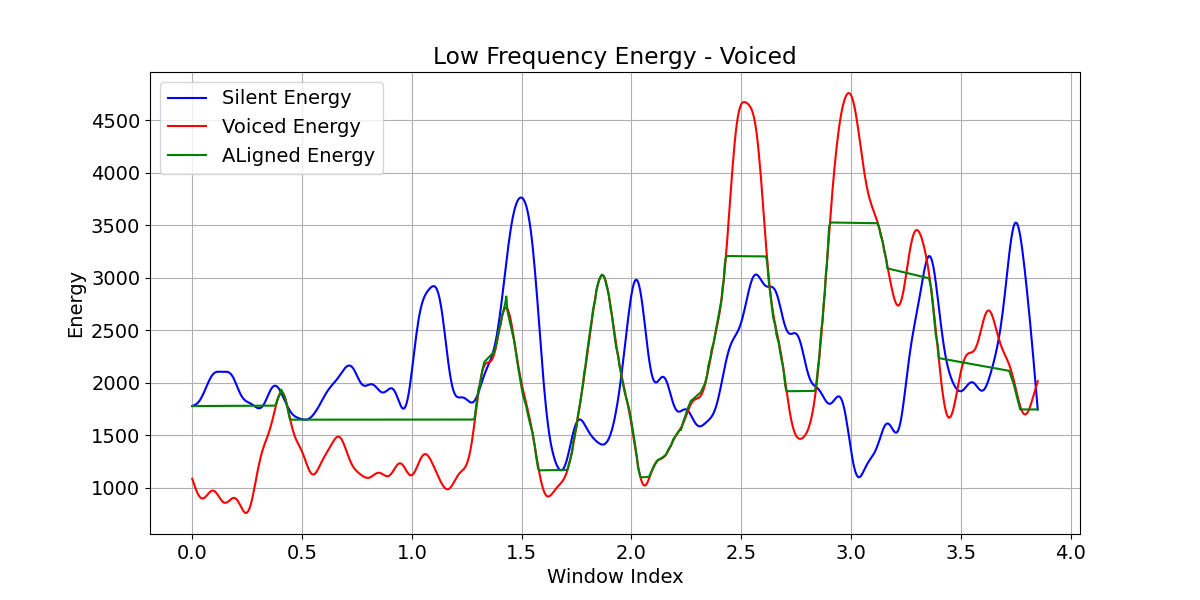

In [493]:
#plot silent energy mean across channels and voiced energy mean across channels
#use np.arange to create x axis for the plot
idx_voiced = 3
idx_silent = 7
x_axis = np.arange(silent_wl.shape[1])/200
t_audio = np.linspace(start_ts_audio - start_ts_audio, stop_ts_audio - start_ts_audio, utterances_audio_voiced[idx_voiced].shape[0])

plt.figure(figsize=(12, 6))

plt.plot(x_axis,y1, label='Silent Energy', color='blue')
plt.title('Low Frequency Energy - Silent')
plt.xlabel('Window Index')
plt.ylabel('Energy')
plt.grid()

plt.plot(x_axis, y2, label='Voiced Energy', color='red')
plt.plot(x_axis, y1_warped, label='ALigned Energy', color='green')
plt.legend()

# plt.subplot(3, 1, 3)
# plt.plot(t_audio, utterances_audio_voiced[idx_voiced]*600, label='Audio Silent', color='blue')

plt.title('Low Frequency Energy - Voiced')

Text(0.5, 1.0, 'Low Frequency Energy - Voiced')

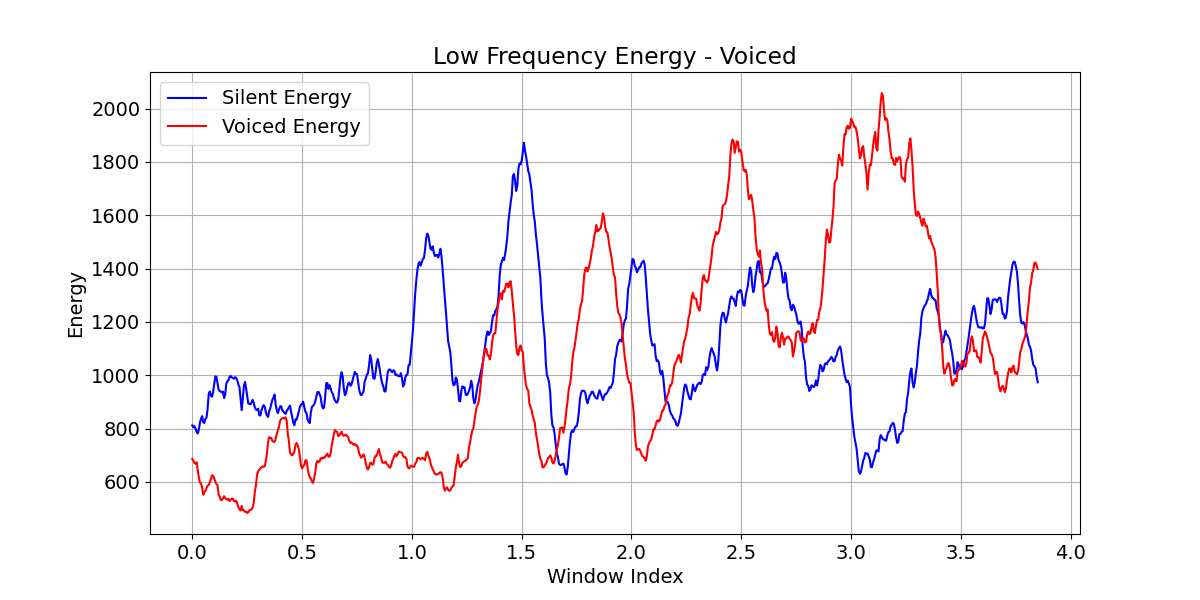

In [456]:
#plot silent energy mean across channels and voiced energy mean across channels
#use np.arange to create x axis for the plot
idx_voiced = 3
idx_silent = 7
x_axis = np.arange(silent_wl.shape[1])/200
t_audio = np.linspace(start_ts_audio - start_ts_audio, stop_ts_audio - start_ts_audio, utterances_audio_voiced[idx_voiced].shape[0])

plt.figure(figsize=(12, 6))

plt.plot(x_axis,np.mean(silent_wl, axis=2)[idx_silent], label='Silent Energy', color='blue')
plt.title('Low Frequency Energy - Silent')
plt.xlabel('Window Index')
plt.ylabel('Energy')
plt.grid()

plt.plot(x_axis, np.mean(voiced_wl, axis=2)[idx_voiced], label='Voiced Energy', color='red')
# plt.plot(x_axis, y1_warped, label='ALigned Energy', color='green')
plt.legend()

# plt.subplot(3, 1, 3)
# plt.plot(t_audio, utterances_audio_voiced[idx_voiced]*600, label='Audio Silent', color='blue')

plt.title('Low Frequency Energy - Voiced')


In [221]:
pred_aligned = dtw_aligner(silent_wl[idx_silent], voiced_wl[idx_voiced])

In [326]:
y1.shape

(771,)

In [312]:
len(t1_full), len(t2_full)

(8, 8)

In [424]:
from scipy.signal import find_peaks
min_prominence = 250
peaks1, _ = find_peaks(y1, prominence=(min_prominence, None))
peaks2, _ = find_peaks(y2, prominence=(min_prominence, None))
t1 = peaks1 
t2 = peaks2 

import numpy as np
from scipy.interpolate import interp1d

# Always include the endpoints to avoid extrapolation
t1_full = np.concatenate([[0], t1, [len(y1)]])
t2_full = np.concatenate([[0], t2, [len(y2)]])
warp_map = interp1d(t1_full, t2_full, kind='linear')

# Apply to every sample in y1
x1 = np.arange(len(y1))
x1_warped = warp_map(x1)
y1_aligned = np.interp(x1_warped, x1, y1)

ValueError: x and y arrays must be equal in length along interpolation axis.

In [425]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

# 1) detect peaks by prominence
min_prom = 250
peaks1, _ = find_peaks(y1, prominence=(min_prom, None))
peaks2, _ = find_peaks(y2, prominence=(min_prom, None))
peaks1, peaks2 = np.sort(peaks1), np.sort(peaks2)

# 2) for each silent peak, find the nearest voiced peak only if it's close enough
max_shift = 50   # max windows you’re willing to warp for a peak
matched1, matched2 = [], []
j = 0
for p in peaks1:
    # advance j until peaks2[j] is the closest
    while j+1 < len(peaks2) and abs(peaks2[j+1] - p) < abs(peaks2[j] - p):
        j += 1
    if abs(peaks2[j] - p) <= max_shift:
        matched1.append(p)
        matched2.append(peaks2[j])
    # else: drop this silent peak, it has no good voiced partner

matched1 = np.array(matched1)
matched2 = np.array(matched2)

# 3) make sure we still have enough anchors
if len(matched1) < 2:
    raise RuntimeError("Too few matched peaks! Try lowering max_shift or min_prominence.")

# 4) build full anchor lists (include endpoints)
anchors_src = np.r_[0, matched1, len(y1)-1]
anchors_tgt = np.r_[0, matched2, len(y2)-1]

# 5) sanity‐check monotonicity
assert np.all(np.diff(anchors_src) > 0), "Source anchors not strictly increasing!"
assert np.all(np.diff(anchors_tgt) > 0), "Target anchors not strictly increasing!"

# 6) piecewise‐linear warp
warp_fn = interp1d(
    anchors_src, anchors_tgt,
    kind='linear',
    bounds_error=False,
    fill_value=(0, len(y2)-1),
    assume_sorted=True
)

# 7) apply warp
x = np.arange(len(y1), dtype=float)
x_w = warp_fn(x)
y1_warped = np.interp(x_w, x, y1)

In [406]:
# --- 2) Detect peaks by prominence ---
min_prom = 200
peaks1, _ = find_peaks(y1, prominence=(min_prom, None), height=np.mean(y1))
peaks2, _ = find_peaks(y2, prominence=(min_prom, None), height=np.mean(y2))
peaks1, peaks2 = np.sort(peaks1), np.sort(peaks2)


# --- 3) Greedy nearest‑neighbor matching of peaks1 → peaks2 ---
matched1, matched2 = [], []
j = 0
for p in peaks1:
    # advance j so peaks2[j] is the closest to p
    while (j+1 < len(peaks2) and 
           abs(peaks2[j+1] - p) < abs(peaks2[j] - p)):
        j += 1
    matched1.append(p)
    matched2.append(peaks2[j-1])
    j += 1

matched1 = np.array(matched1)
matched2 = np.array(matched2)


# --- 4) Build full anchor lists (include start=0 and end=len−1) ---
anchors_src = np.r_[0, matched1, len(y1)-1]
anchors_tgt = np.r_[0, matched2, len(y2)-1]

# sanity checks
assert np.all(np.diff(anchors_src) > 0), "Source anchors not increasing!"
assert np.all(np.diff(anchors_tgt) > 0), "Target anchors not increasing!"


# --- 5) Create piecewise‑linear warp map ---
# Pre‑allocate warped time‐axis
x_src    = np.arange(len(y1), dtype=float)
x_warped = np.empty_like(x_src)

# For each interval [k → k+1] in anchors, linearly map:
for k in range(len(anchors_src)-1):
    a_src, b_src = anchors_src[k],   anchors_src[k+1]
    a_tgt, b_tgt = anchors_tgt[k],   anchors_tgt[k+1]
    
    # indices in this segment
    idx = np.arange(a_src, b_src, dtype=float)
    
    # linear scale factor
    scale = (b_tgt - a_tgt) / (b_src - a_src)
    
    # warp every sample in [a_src…b_src)
    x_warped[idx.astype(int)] = a_tgt + (idx - a_src)*scale

# last point
x_warped[-1] = anchors_tgt[-1]


# --- 6) Resample y1 onto warped time axis ---
y1_aligned = np.interp(x_warped, x_src, y1)

AssertionError: Target anchors not increasing!

In [426]:
peaks1, peaks2

(array([216, 301, 406, 532, 672, 748], dtype=int64),
 array([286, 373, 496, 629], dtype=int64))

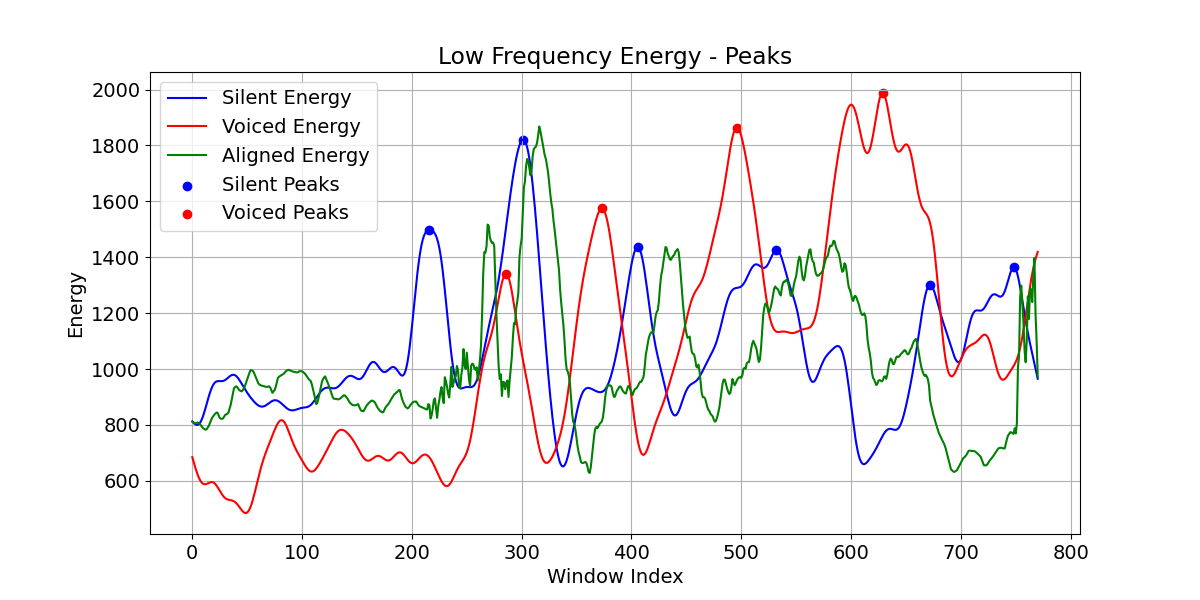

In [427]:
#plot the peaks on y1 an y2
plt.figure(figsize=(12, 6))
plt.plot(range(len(y1)), y1, label='Silent Energy', color='blue')
plt.plot(range(len(y1)), y2, label='Voiced Energy', color='red')
plt.plot(range(len(y1)), y1_aligned, label='Aligned Energy', color='green')
plt.scatter(peaks1, y1[peaks1], color='blue', marker='o', label='Silent Peaks')
plt.scatter(peaks2, y2[peaks2], color='red', marker='o', label='Voiced Peaks')
plt.title('Low Frequency Energy - Peaks')   
plt.xlabel('Window Index')
plt.ylabel('Energy')
plt.grid()
plt.legend()
plt.show()

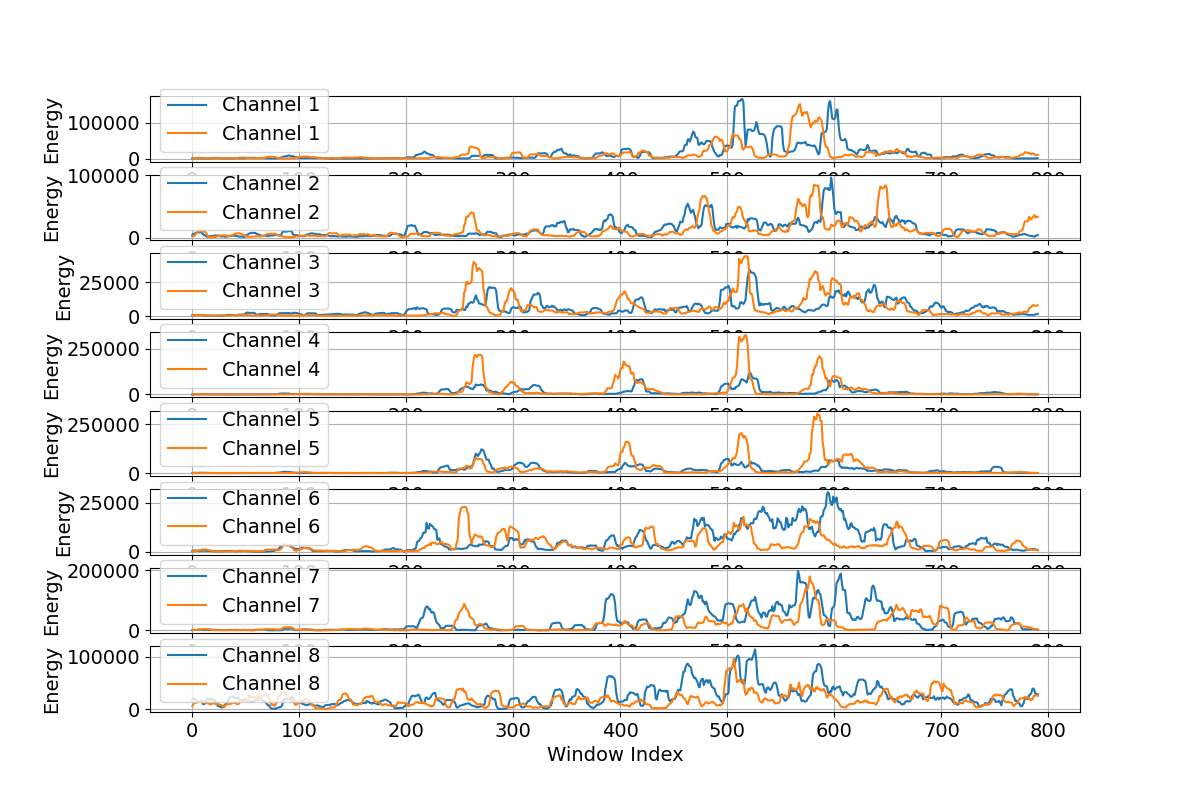

In [121]:
#plot silent energy for each channel create a subplot for each channel
plt.figure(figsize=(12, 8))
for i in range(silent_energy.shape[2]): 
    plt.subplot(silent_energy.shape[2], 1, i + 1)
    sns.lineplot(x=np.arange(silent_energy.shape[1]), y=silent_energy[0, :, i], label=f'Channel {i + 1}')
    sns.lineplot(x=np.arange(voiced_energy.shape[1]), y=voiced_energy[0, :, i], label=f'Channel {i + 1}')

    # plt.title(f'Silent Energy - Channel {i + 1}')
    plt.xlabel('Window Index')
    plt.ylabel('Energy')
    plt.grid()
    plt.legend()


In [101]:
silent_emg.shape
voiced_emg.shape

(93, 8000, 8)

In [83]:
utterances_emg_voiced[].shape

(9000, 8)

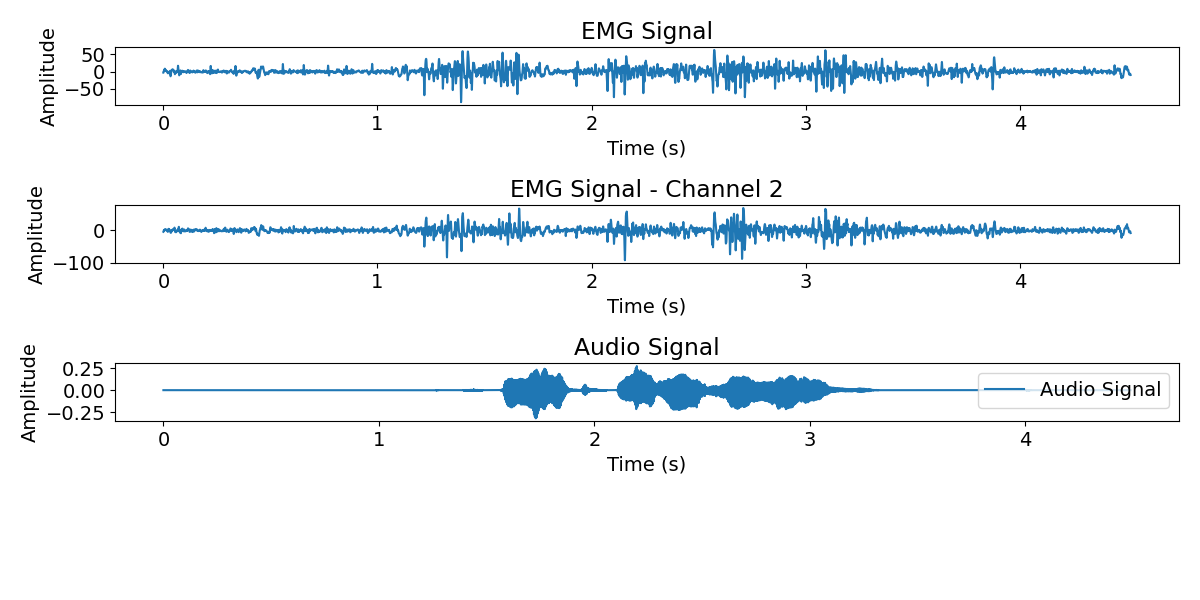

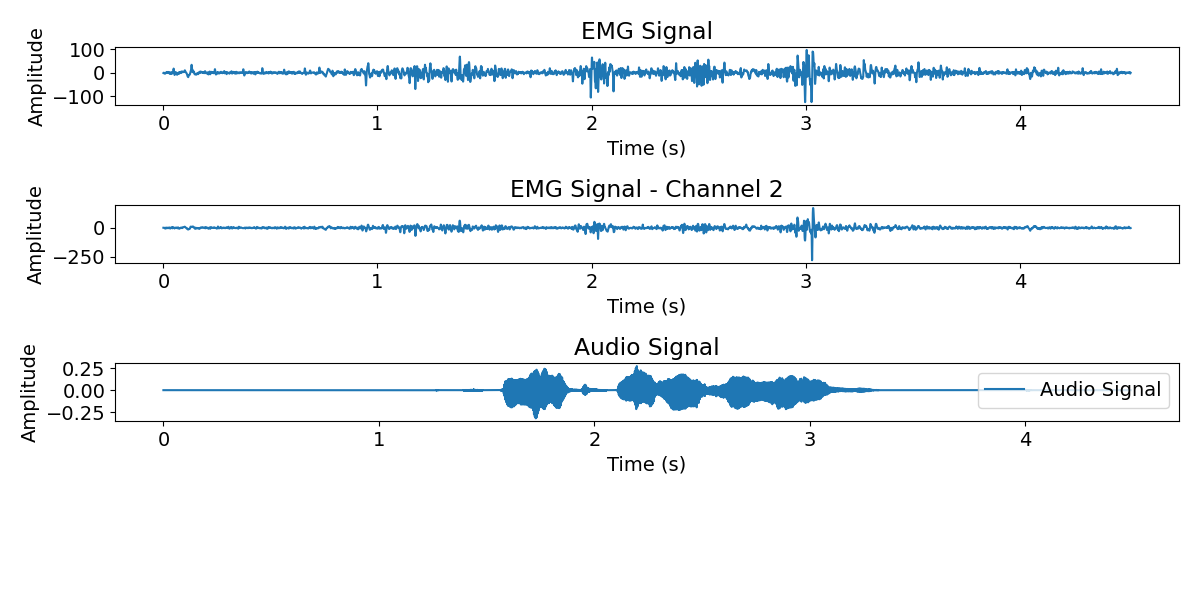

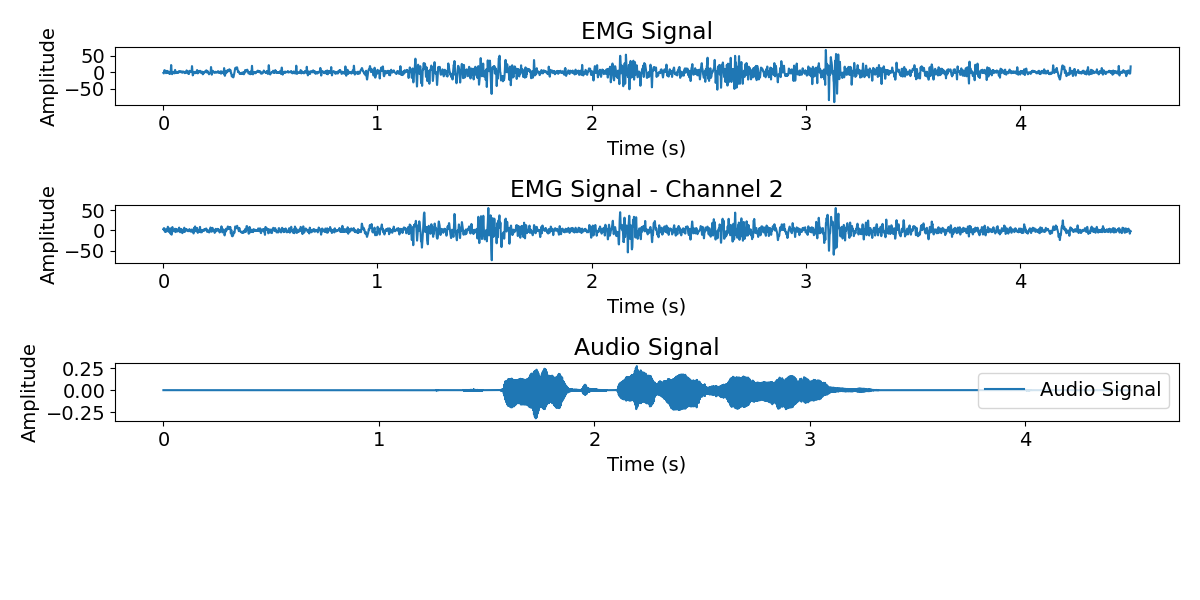

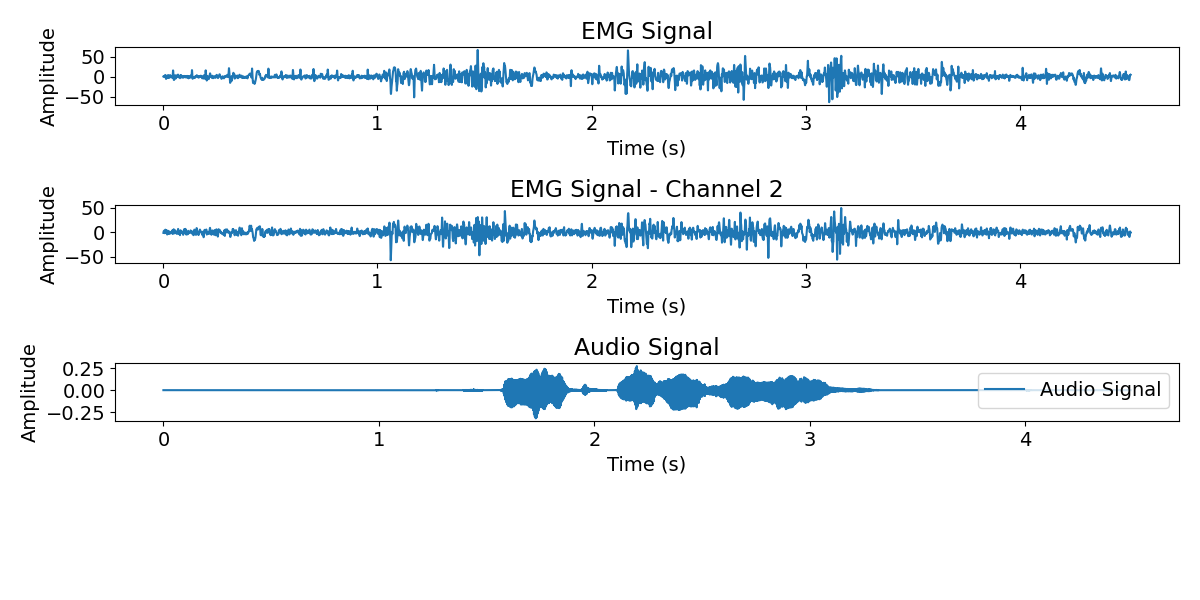

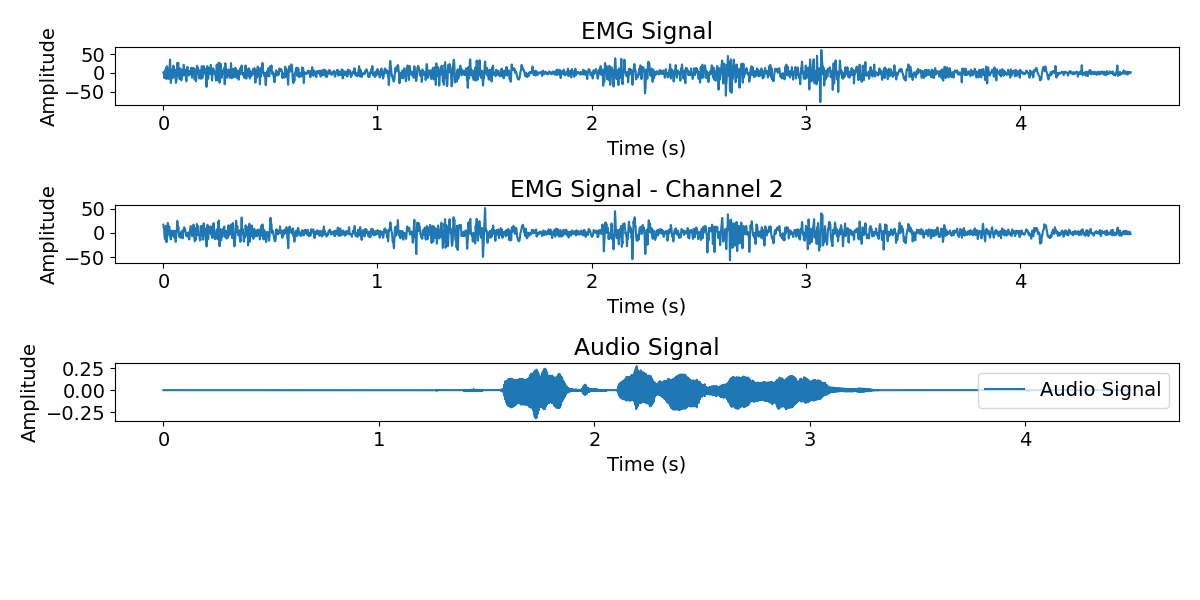

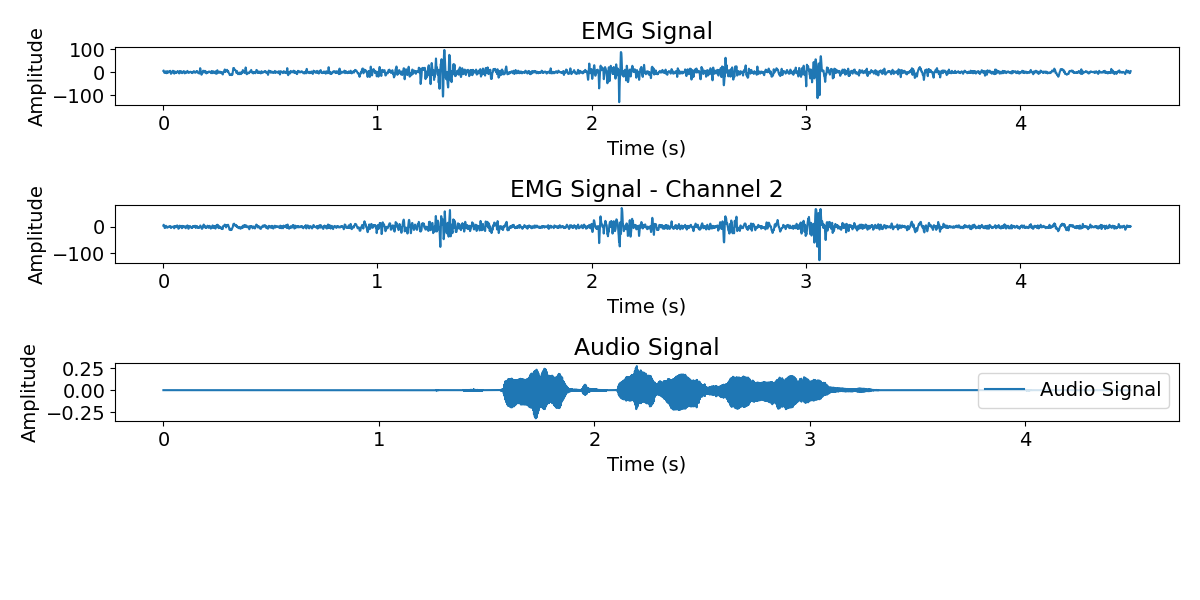

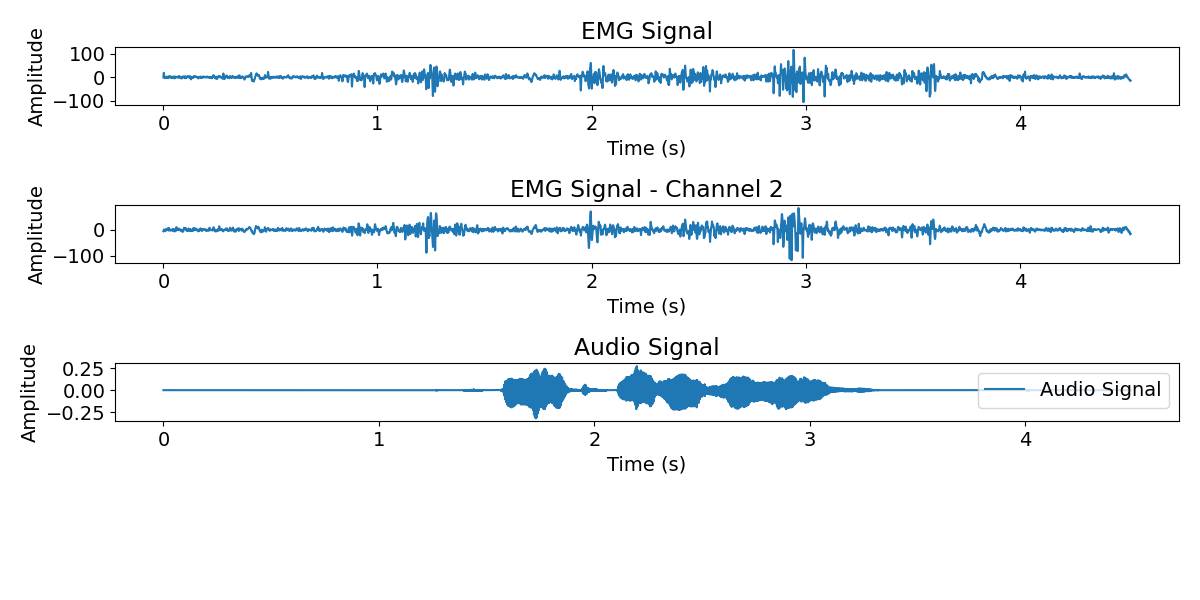

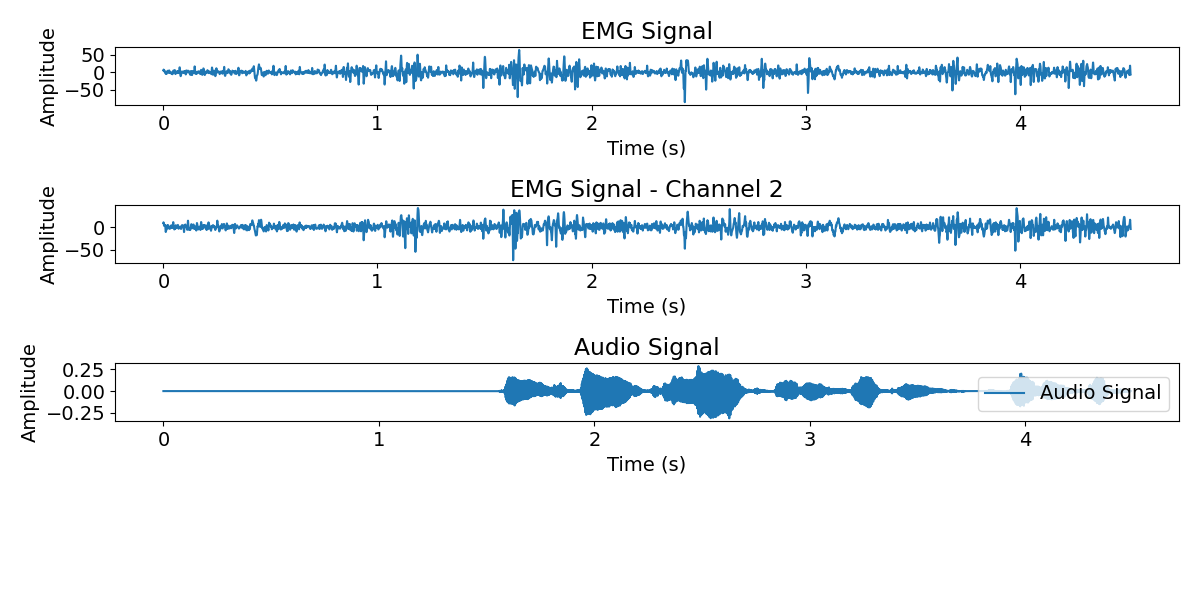

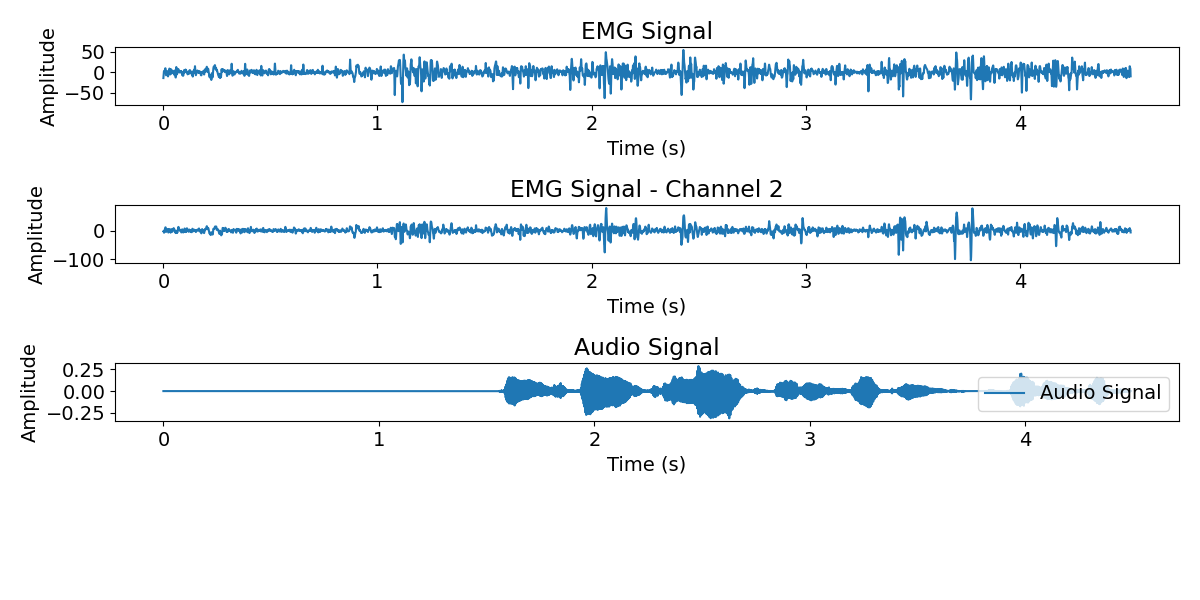

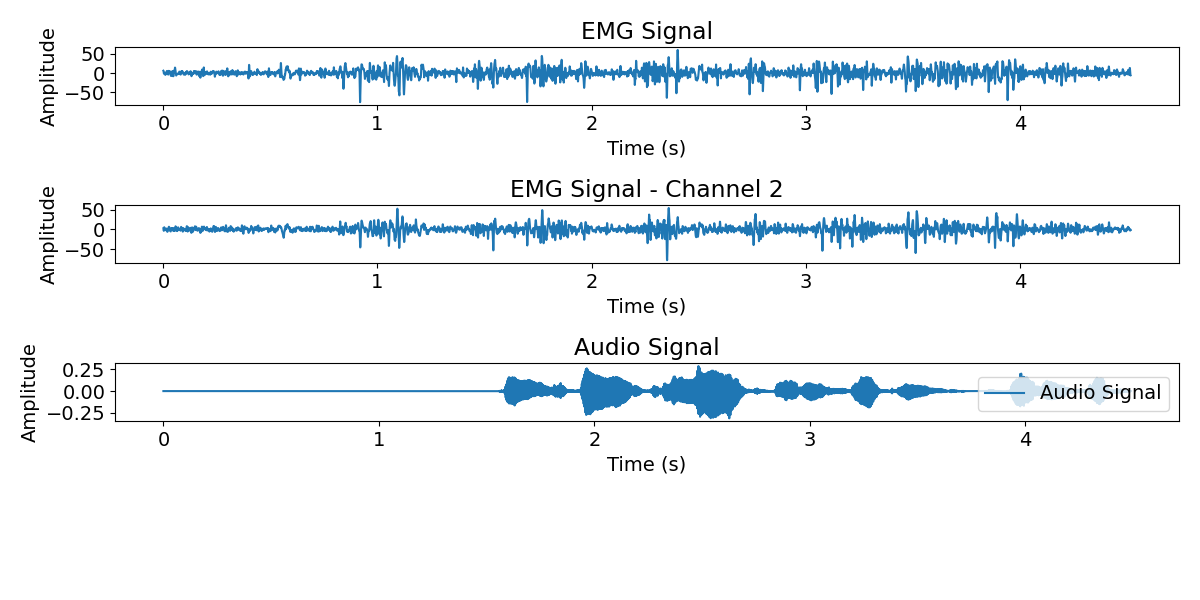

In [443]:
for i in range(len(utterances_audio_silent[:10])):
    #create t_emg and t_audio vectors using linspace    
    t_emg = np.linspace(start_ts_emg - start_ts_emg, stop_ts_emg - start_ts_emg, utterances_emg_silent[i].shape[0])
    t_audio = np.linspace(start_ts_audio - start_ts_audio, stop_ts_audio - start_ts_audio, utterances_audio_silent[i].shape[0])
    # t_trigger = np.linspace(start_ts - start_ts, stop_ts - start_ts, trigger.shape[0])
    #create t_emg and t_audio vectors using np arange, do no tuse ts
    # t_emg = np.arange(0, emg_signal.shape[0] / emg_data["emg"]["fs"], 1 / emg_data["emg"]["fs"])
    # t_audio = np.arange(0, audio_signal.shape[0] / audio_data["audio"]["fs"], 1 / audio_data["audio"]["fs"])
    min_amplitude = -100
    max_amplitude = 100
    #plot the emg signal and audio signal using subplots, separate the two emg channels in tow subplots and the audio signal in a third subplot
    plt.rcParams.update({'font.size': 14})  # Set default font size for plots
    plt.figure(figsize=(12, 6))
    plt.subplot(4, 1, 1)
    plt.plot(t_emg, utterances_emg_silent[i][:, 4], label='EMG Channel 1')
    plt.title('EMG Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    #add ylim to the plot
    # plt.ylim(min_amplitude, max_amplitude)
    # plt.legend()
    plt.subplot(4, 1, 2)
    plt.plot(t_emg, utterances_emg_silent[i][:, 3], label='EMG Channel 2')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    # plt.ylim(min_amplitude, max_amplitude)
    # plt.legend()
    plt.title('EMG Signal - Channel 2')

    plt.subplot(4, 1, 3)
    plt.plot(t_audio, utterances_audio_silent[i][:, 0], label='Audio Signal')
    plt.title('Audio Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()

    # plt.subplot(4, 1, 4)
    # plt.plot(t_trigger, trigger, label='Trigger Signal')
    # plt.title('Trigger Signal')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Amplitude')
    # # plt.legend()

    plt.show()

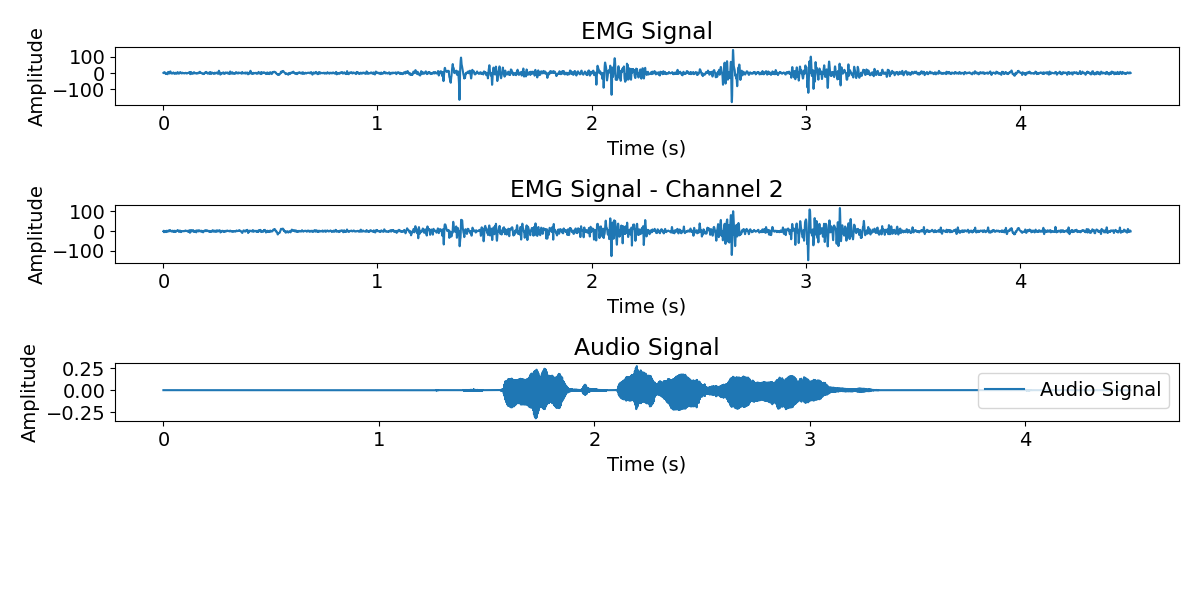

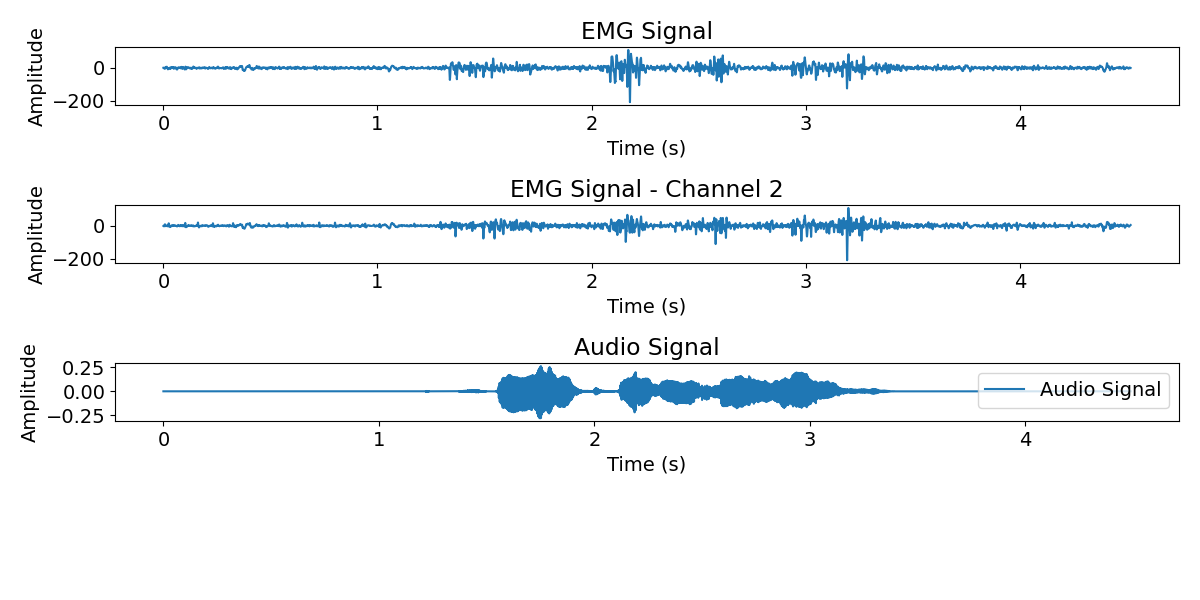

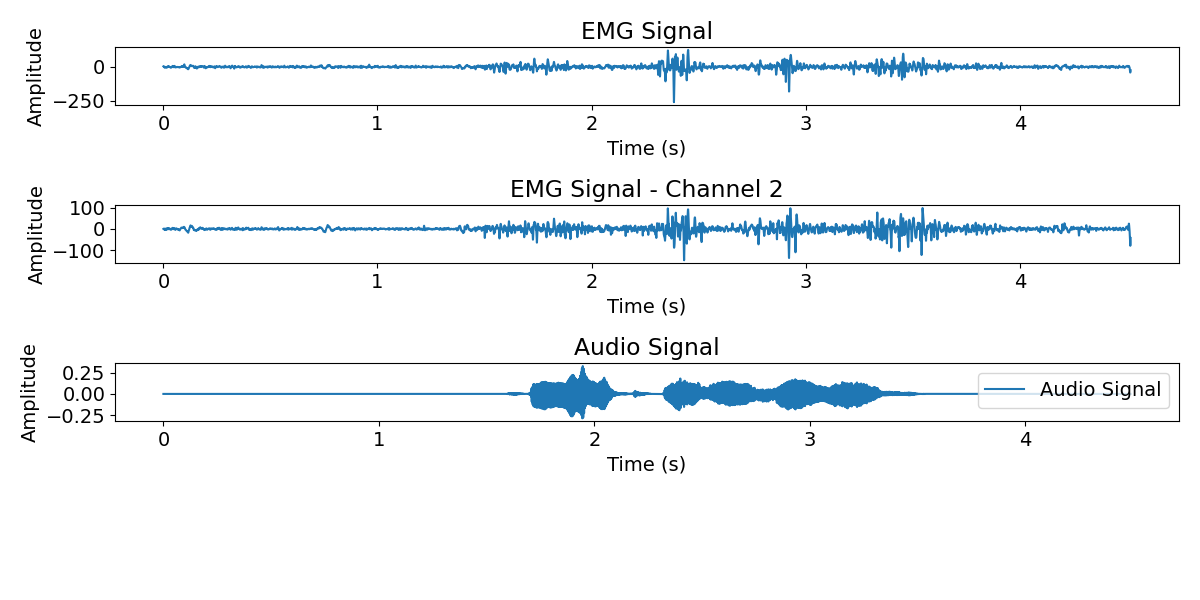

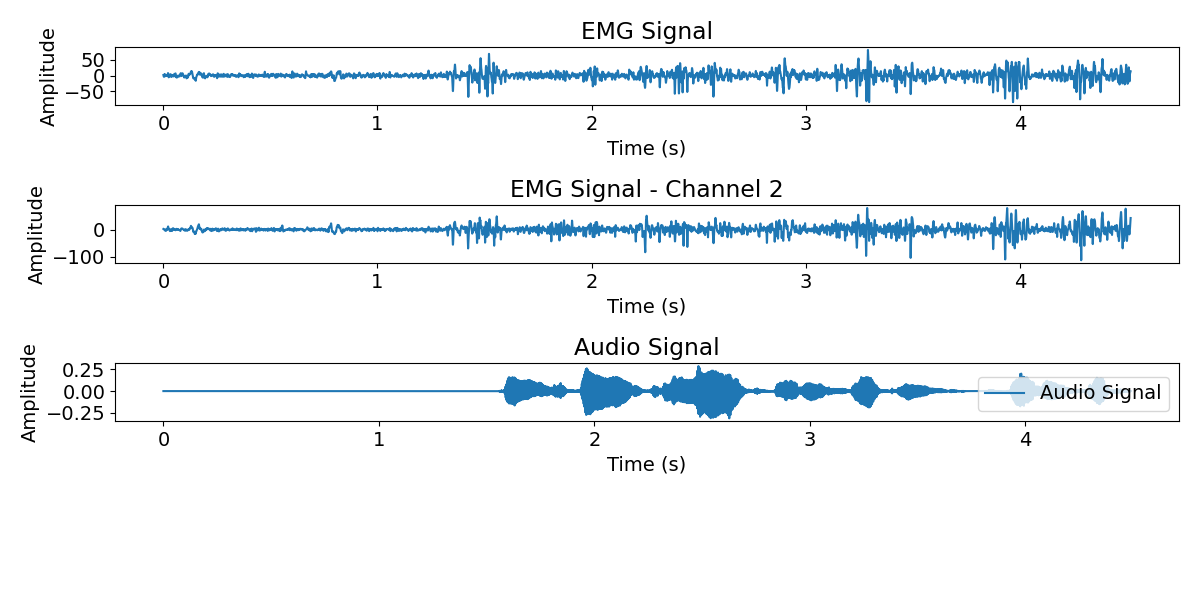

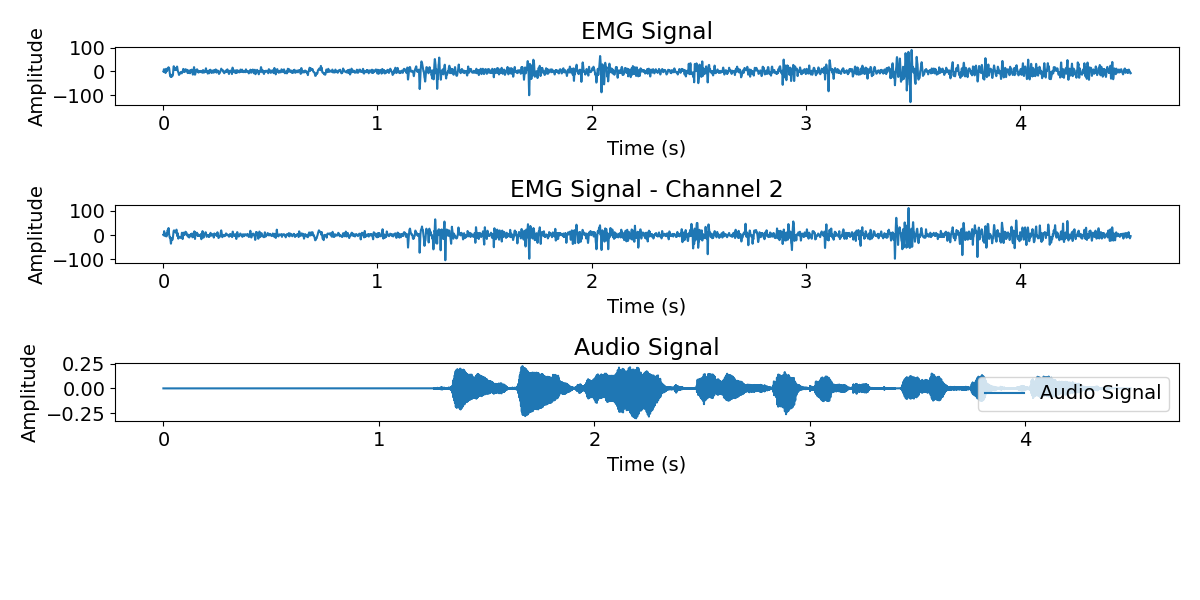

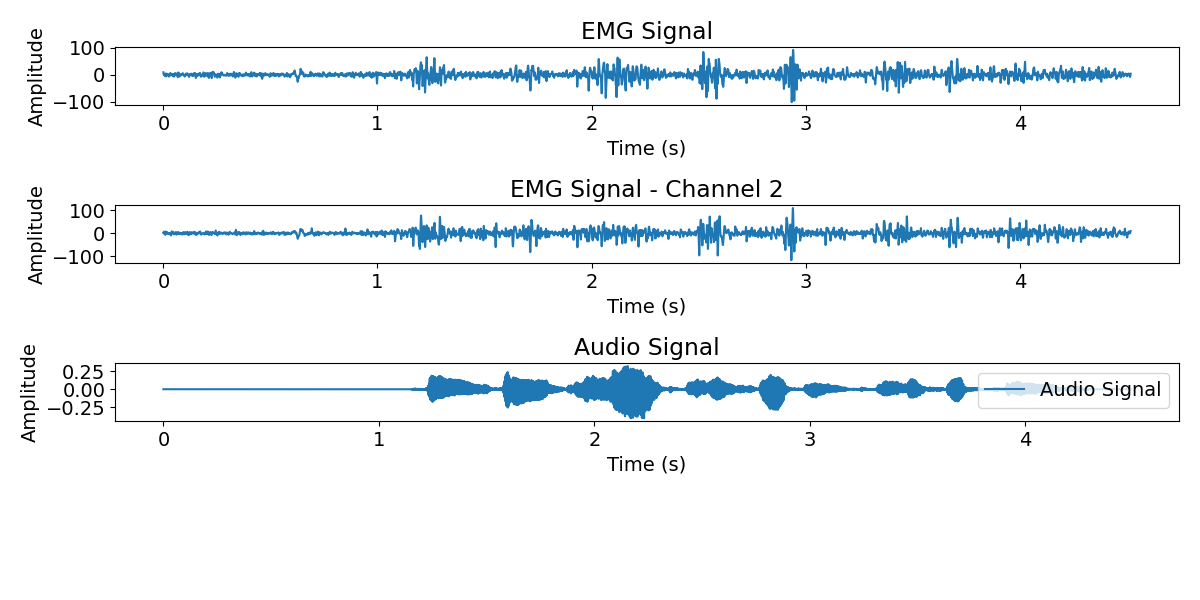

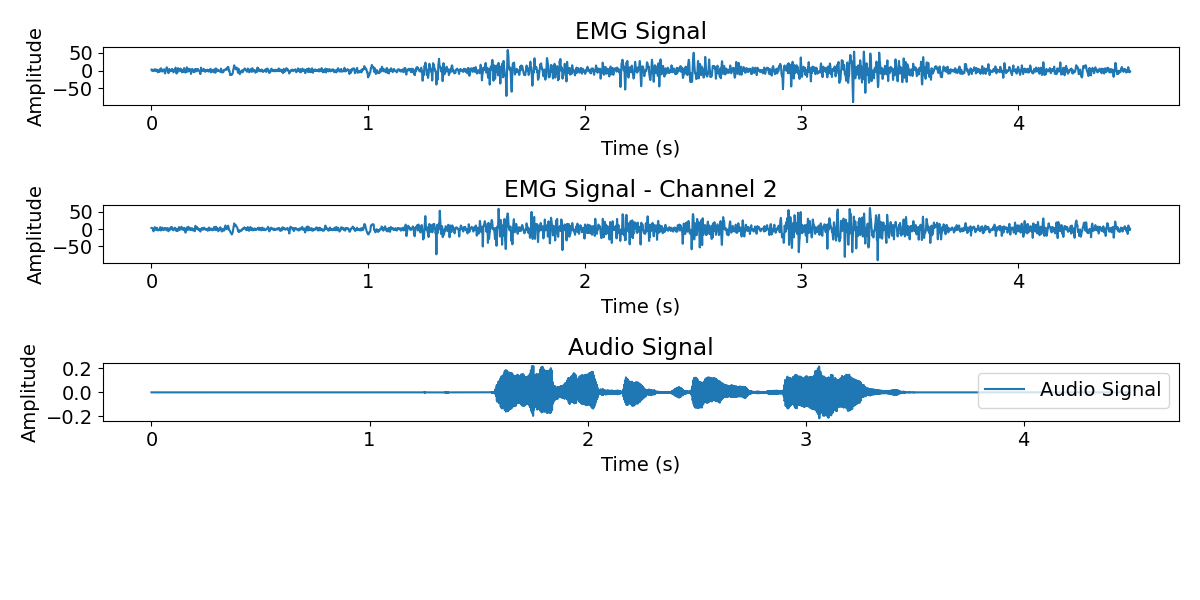

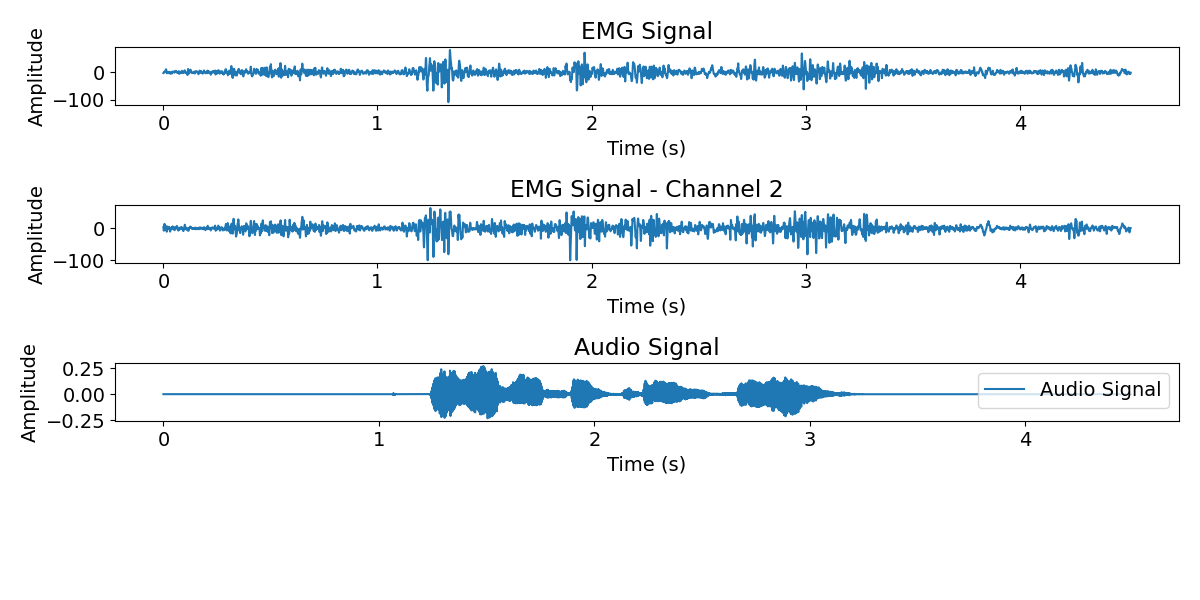

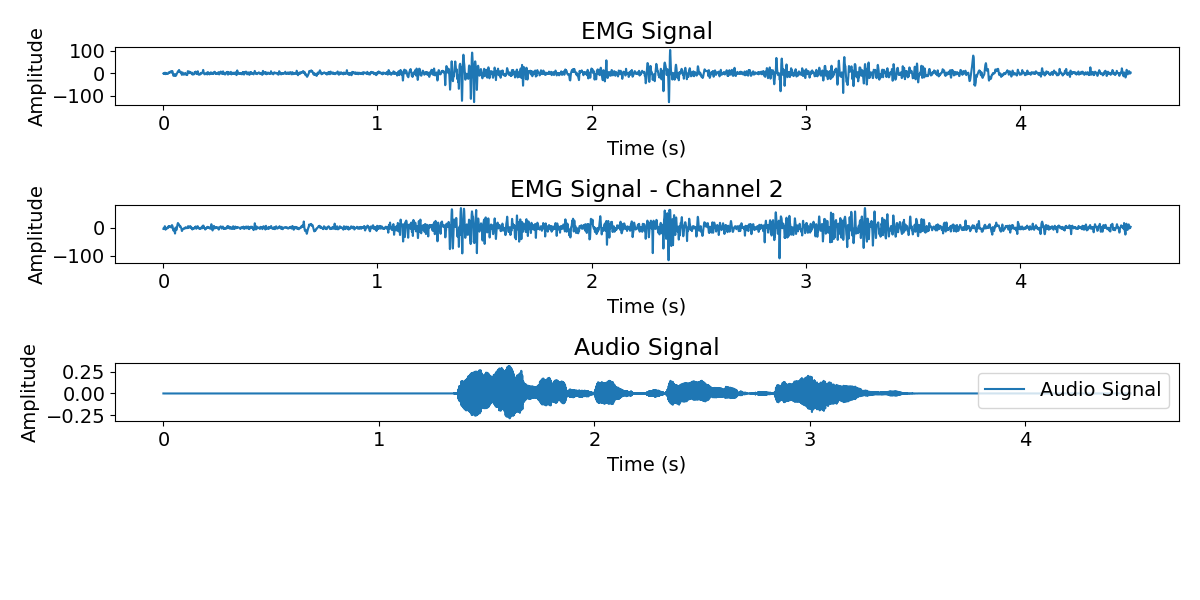

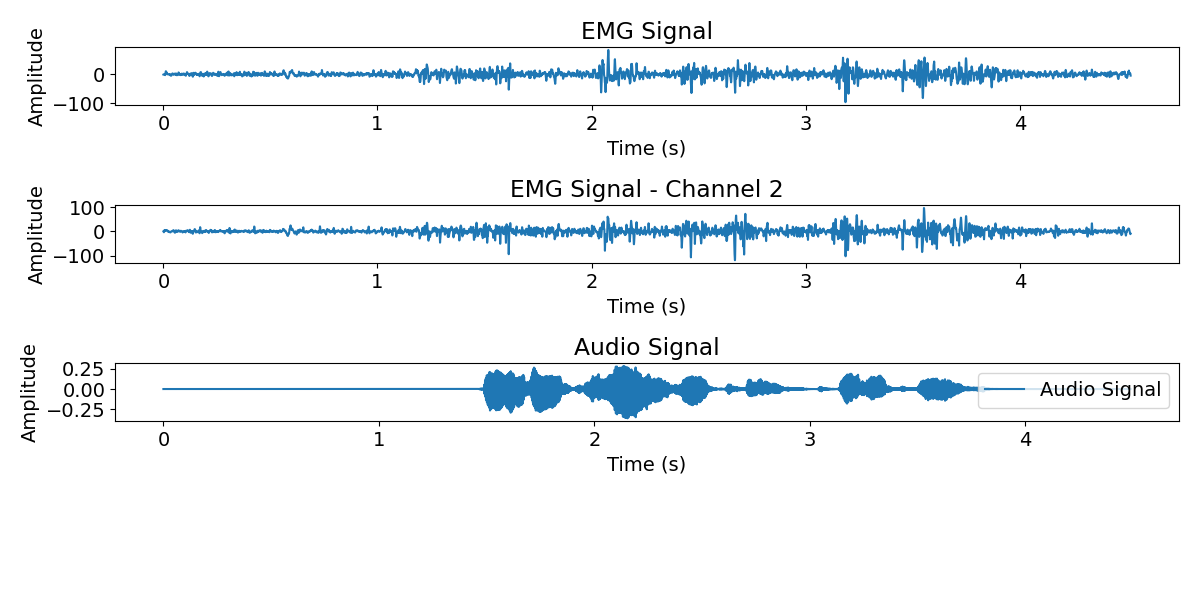

In [444]:
for i in range(len(utterances_audio_silent[:10])):
    #create t_emg and t_audio vectors using linspace    
    t_emg = np.linspace(start_ts_emg - start_ts_emg, stop_ts_emg - start_ts_emg, utterances_emg_voiced[i].shape[0])
    t_audio = np.linspace(start_ts_audio - start_ts_audio, stop_ts_audio - start_ts_audio, utterances_audio_voiced[i].shape[0])
    # t_trigger = np.linspace(start_ts - start_ts, stop_ts - start_ts, trigger.shape[0])
    #create t_emg and t_audio vectors using np arange, do no tuse ts
    # t_emg = np.arange(0, emg_signal.shape[0] / emg_data["emg"]["fs"], 1 / emg_data["emg"]["fs"])
    # t_audio = np.arange(0, audio_signal.shape[0] / audio_data["audio"]["fs"], 1 / audio_data["audio"]["fs"])
    min_amplitude = -100
    max_amplitude = 100
    #plot the emg signal and audio signal using subplots, separate the two emg channels in tow subplots and the audio signal in a third subplot
    plt.rcParams.update({'font.size': 14})  # Set default font size for plots
    plt.figure(figsize=(12, 6))
    plt.subplot(4, 1, 1)
    plt.plot(t_emg, utterances_emg_voiced[i][:, 3], label='EMG Channel 1')
    plt.title('EMG Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    #add ylim to the plot
    # plt.ylim(min_amplitude, max_amplitude)
    # plt.legend()
    plt.subplot(4, 1, 2)
    plt.plot(t_emg, utterances_emg_voiced[i][:, 4], label='EMG Channel 2')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    # plt.ylim(min_amplitude, max_amplitude)
    # plt.legend()
    plt.title('EMG Signal - Channel 2')

    plt.subplot(4, 1, 3)
    plt.plot(t_audio, utterances_audio_voiced[i][:, 0], label='Audio Signal')
    plt.title('Audio Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()

    # plt.subplot(4, 1, 4)
    # plt.plot(t_trigger, trigger, label='Trigger Signal')
    # plt.title('Trigger Signal')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Amplitude')
    # # plt.legend()

    plt.show()

In [ ]:
# write the function to write wav you can use scipy.io.wavfile.write
from scipy.io import wavfile
def write_wav(filename: str, data: np.ndarray, fs: float):
    """
    Write a WAV file.

    Parameters
    ----------
    filename : str
        The name of the file to write.
    data : np.ndarray
        The audio data to write.
    fs : float
        The sampling frequency of the audio data.
    """
    wavfile.write(filename, int(fs), data.astype(np.float32))


In [32]:
# use librosa to write the audio signal to a wav file using soundfile backend
import soundfile as sf
def write_wav_librosa(filename: str, data: np.ndarray, fs: float):
    """
    Write a WAV file using librosa.

    Parameters
    ----------
    filename : str
        The name of the file to write.
    data : np.ndarray
        The audio data to write.
    fs : float
        The sampling frequency of the audio data.
    """
    y =  (data * 32767).astype('int16')
    sf.write(filename, y, int(fs), format='WAV')

In [33]:
import os
#create a list with the nato alphabet up to delta
nato_alphabet = [
    "Alfa",
    "Bravo",
    "Charlie",
    "Delta",
    "Echo",
    "Foxtrot",
    "Golf",
    "Hotel",
    "India",
    "Juliett",
    "Kilo",
    "Lima",
    "Mike",
    "November",
    "Oscar",
    "Papa",
    "Quebec",
    "Romeo",
    "Sierra",
    "Tango",
    "Uniform",
    "Victor",
    "Whiskey",
    "Xray",
    "Yankee",
    "Zulu"
    
]
# create a dictionary to map the trigger values to the nato alphabet
trigger_map = {i + 1: nato_alphabet[i] for i in range(len(nato_alphabet))}
# save the emg in a npy file, save a file for each utterance, some utterances trigger values are the same so put a number at the end of the file name
#put a number after name on the same values inside trigger_values, the number should restart from 1 for each value, create the file if not exists
path = f"C:/Users/pierangelo/Documents/silent_speech/modified/full_nato_10reps_diff_silent_grace"
if not os.path.exists(f"{path}/audio"):
    os.makedirs(f"{path}/audio")
if not os.path.exists(f"{path}/emg"):
    os.makedirs(f"{path}/emg")
num_file = 1
for i, trigger_value in enumerate(np.unique(trigger_values)):
    num_file = 1
    for j in range(len(trigger_values)):
        if trigger_values[j] == trigger_value:
            write_wav_librosa(f"{path}/audio/{trigger_map[trigger_values[j]]}_{num_file}.wav", utterances_audio[j][:,0], 48000)
            np.save(f"{path}/emg/{trigger_map[trigger_values[j]]}_{num_file}.npy", utterances_emg[j])
            num_file += 1

In [ ]:
import os
#create a list with the nato alphabet up to delta
nato_alphabet = [
    "Alfa",
    "Bravo"
    
]
# create a dictionary to map the trigger values to the nato alphabet
trigger_map = {i + 1: nato_alphabet[i] for i in range(len(nato_alphabet))}
# save the emg in a npy file, save a file for each utterance, some utterances trigger values are the same so put a number at the end of the file name
#put a number after name on the same values inside trigger_values, the number should restart from 1 for each value, create the file if not exists
path = f"C:/Users/pierangelo/Documents/silent_speech/alfa_bravo_4reps_diff_ref_pierangelo"
if not os.path.exists(f"{path}/audio"):
    os.makedirs(f"{path}/audio")
if not os.path.exists(f"{path}/emg"):
    os.makedirs(f"{path}/emg")
num_file = 1
for i, trigger_value in enumerate(np.unique(trigger_values)):
    num_file = 1
    for j in range(len(trigger_values)):
        if trigger_values[j] == trigger_value:
            write_wav_librosa(f"{path}/audio/{trigger_map[trigger_values[j]]}_{num_file}.wav", utterances_audio[j][:,0], 48000)
            np.save(f"{path}/emg/{trigger_map[trigger_values[j]]}_{num_file}.npy", utterances_emg[j])
            num_file += 1

In [ ]:
utterances_emg[j].shape

In [ ]:
NCH_EMG = emg_signal.shape[1]
#remove channel 1 from the emg signal



for i in range(len(utterances_audio)):
    #create t_emg and t_audio vectors using linspace    
    t_emg = np.linspace(start_ts - start_ts, stop_ts - start_ts, utterances_emg[i].shape[0])
    t_audio = np.linspace(start_ts - start_ts, stop_ts - start_ts, utterances_audio[i].shape[0])
    #go over the channels of emg and create a single plot for each channel then one subplot for the audio signal
    min_amplitude = -250
    max_amplitude = 250
    plt.figure(figsize=(12, 10))
    for ch in range(NCH_EMG):
        plt.subplot(NCH_EMG + 1 , 1, ch + 1)
        if ch < 4:
            plt.plot(t_emg, utterances_emg[i][:, ch], label=f"ear piece Channel {ch + 1}")
        else:
            plt.plot(t_emg, utterances_emg[i][:, ch], label=f"Neckband Channel {ch + 1 - 4}")
        # plt.ylim(min_amplitude, max_amplitude)
        plt.legend(loc="upper right")
    plt.subplot(NCH_EMG + 1, 1, NCH_EMG + 1)
    plt.plot(t_audio, utterances_audio[i], label="Audio Signal")
    # plt.ylim(min_amplitude, max_amplitude)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()